# User Inputs

In [69]:
#==========
# General Setting
#==========

# set core path
path = '/Users/Mark/Documents/Github/Fantasy_Football/'

db_name = 'Model_Inputs.sqlite3'

# set to position to analyze: 'RB', 'WR', 'QB', or 'TE'
set_pos = 'RB'


#==========
# Data Filtering
#==========

# set year to analyze
set_year = 2018
earliest_year = 2002

# set required touches (or pass thrown) and games for consideration
req_games = 8
req_touch = 50


#==========
# Fantasy Point Values
#==========

# settings for fantasy points
pts = {}
pts['yd_pts'] = 0.1
pts['pass_yd_pts'] = 0.04
pts['td_pts'] = 7
pts['pass_td_pts'] = 5
pts['rec_pts'] = 0.5
pts['fmb_pts'] = -2.0
pts['int_pts'] = -2
pts['sack_pts'] = -1


#==========
# Model Settings
#==========

# VIF threshold to include a feature
vif_thresh = 10000

# number of hypersearch rounds for training ensemble
iter_rounds = 5

# number of time to repeat predictions when generation prior distributions
prior_repeats=5

# whether or not to plot bayes outputs
plot_importance = False

# Load Libraries

In [70]:
# core packages
import pandas as pd
import numpy as np
import os
import sqlite3

# jupyter specifications
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# change directory temporarily to helper scripts
os.chdir(path + 'Scripts/Analysis/Helper_Scripts')

# load custom plot functions
from my_plot import PrettyPlot
PrettyPlot(plt)

# load custom helper functions
from helper_functions import *;

# Merge and Clean Data Files

In [72]:
#==========
# Pull and clean compiled data
#==========

conn = sqlite3.connect(path + 'Data/' + db_name)
df = pd.read_sql_query('SELECT * FROM RB_2018', con=conn)

# split old and new to filter past years based on touches.
# leave all new players in to ensure everyone gets a prediction
old = df[(df[pos[set_pos]['touch_filter']] > req_touch) & (df.games > req_games) & (df.year < set_year-1)].reset_index(drop=True)
this_year = df[df.year==set_year-1]

# merge old and new back together after filtering
df = pd.concat([old, this_year], axis=0)

# create dataframes to store results
df_train_results = pd.DataFrame([old.player, old.year]).T
df_test_results = pd.DataFrame([this_year.player]).T

# calculate FP
df, pts_list = calculate_fp(df, pts, pos=set_pos)

Running Models for rush_yd_per_game
----------------------------------
Running VIF Feature Reduction
Training Ensemble Model
    lgbm    xgb  lasso  ridge   rmse    mae  r2_pred  c_pred  r2_adp  c_adp
0  0.250  0.254  0.250  0.246  17.76  14.12    0.498   0.706   0.378  0.615
2  0.250  0.251  0.250  0.248  18.13  14.70    0.488   0.698   0.378  0.615
1  0.250  0.248  0.252  0.249  18.17  14.71    0.492   0.701   0.378  0.615
4  0.252  0.249  0.251  0.248  18.17  14.64    0.475   0.689   0.378  0.615
3  0.247  0.249  0.254  0.250  18.34  14.76    0.485   0.696   0.378  0.615


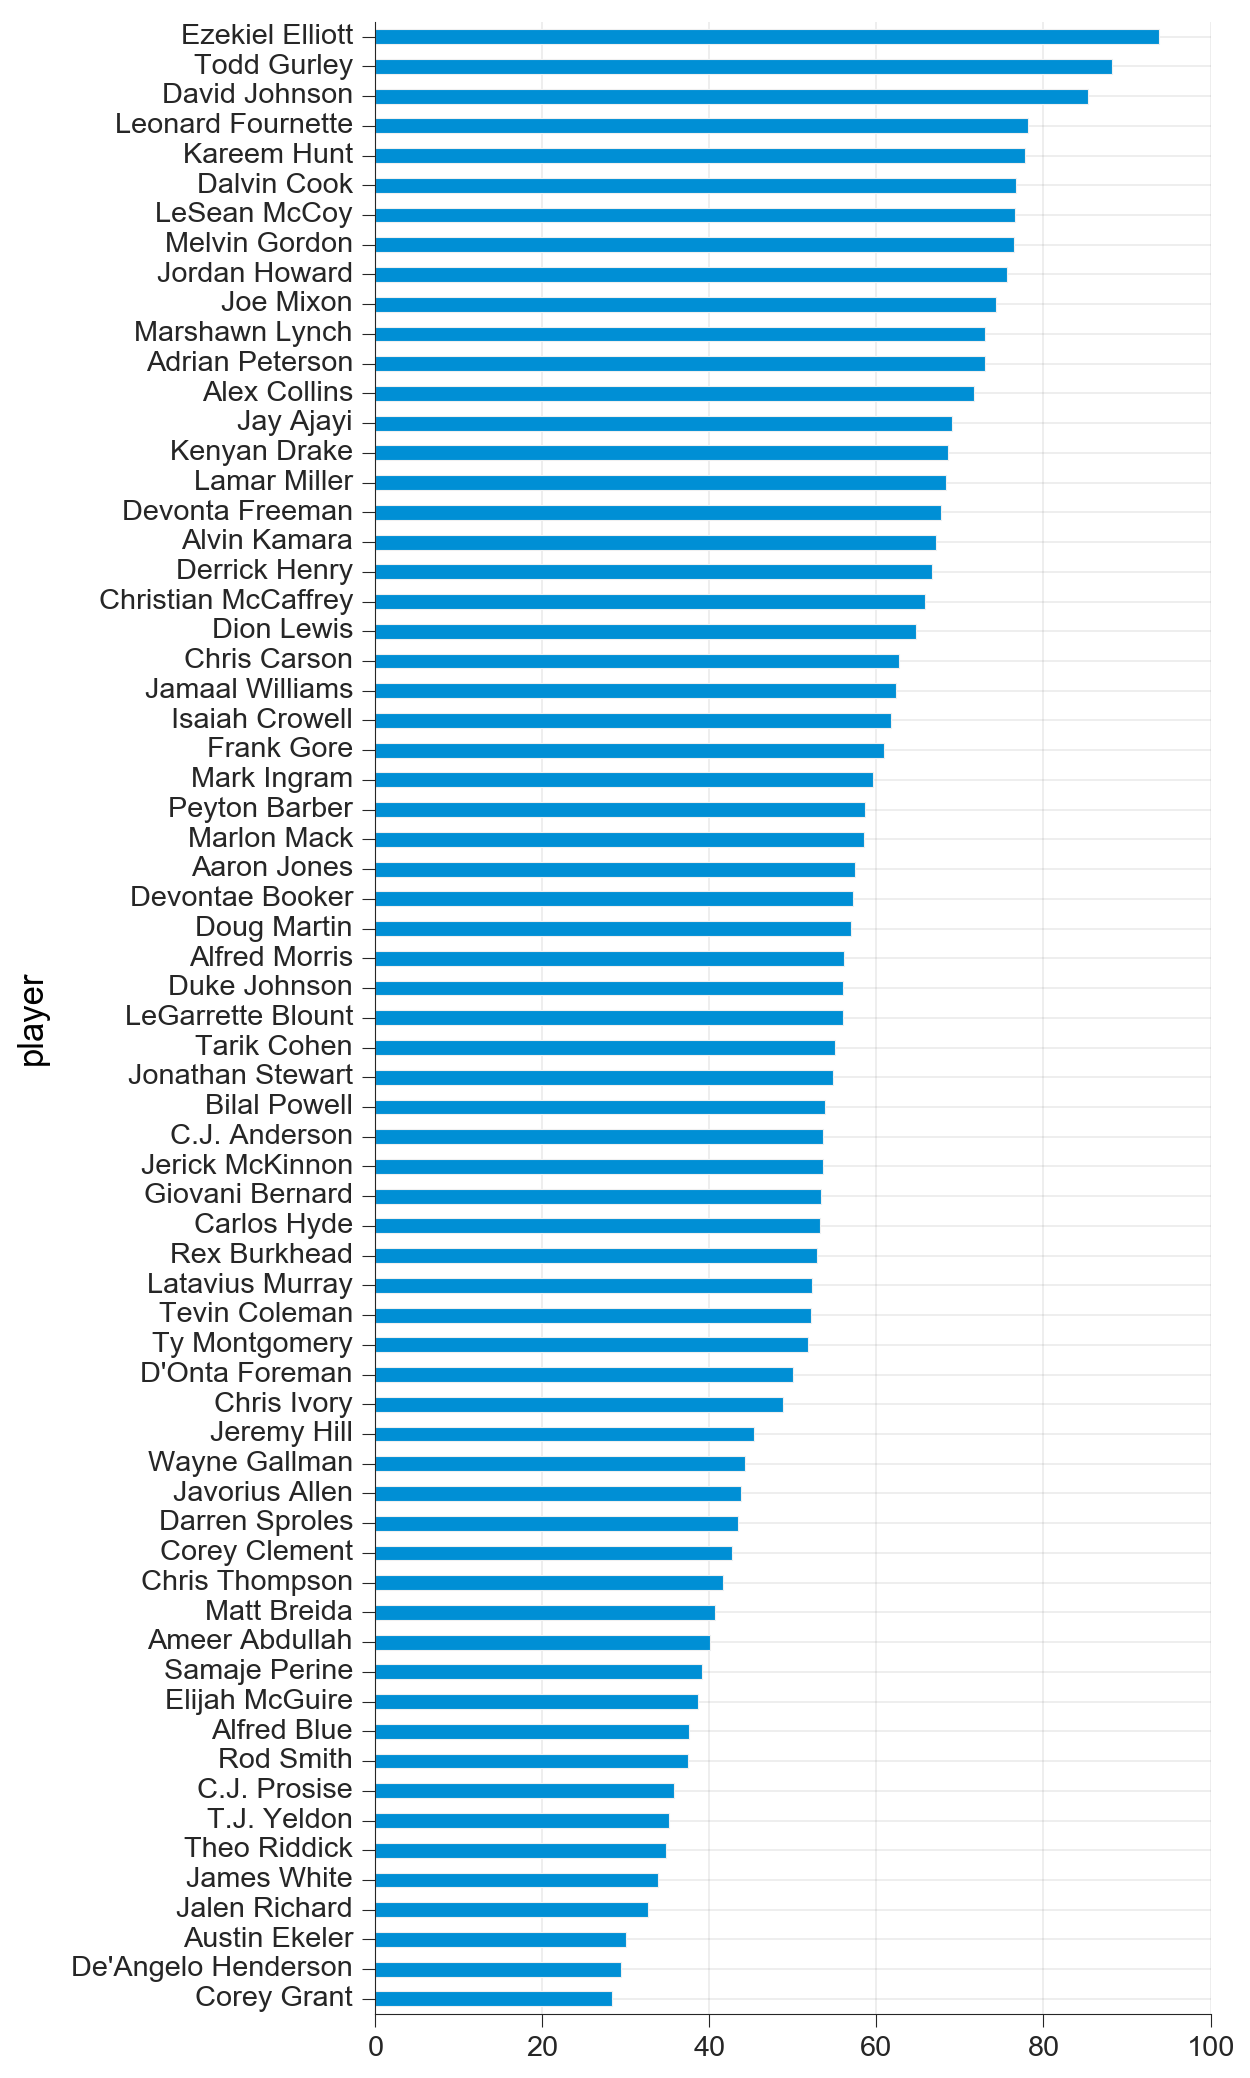

Running Models for rec_yd_per_game
----------------------------------
Running VIF Feature Reduction
Training Ensemble Model
    lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
0  0.250  0.249  0.249  0.251  8.99  6.88    0.446   0.668   0.043  0.208
1  0.244  0.251  0.251  0.253  9.07  6.89    0.429   0.655   0.043  0.208
4  0.248  0.248  0.251  0.253  9.13  6.94    0.431   0.657   0.043  0.208
2  0.251  0.247  0.248  0.254  9.15  6.98    0.434   0.659   0.043  0.208
3  0.247  0.246  0.252  0.255  9.17  6.98    0.425   0.652   0.043  0.208


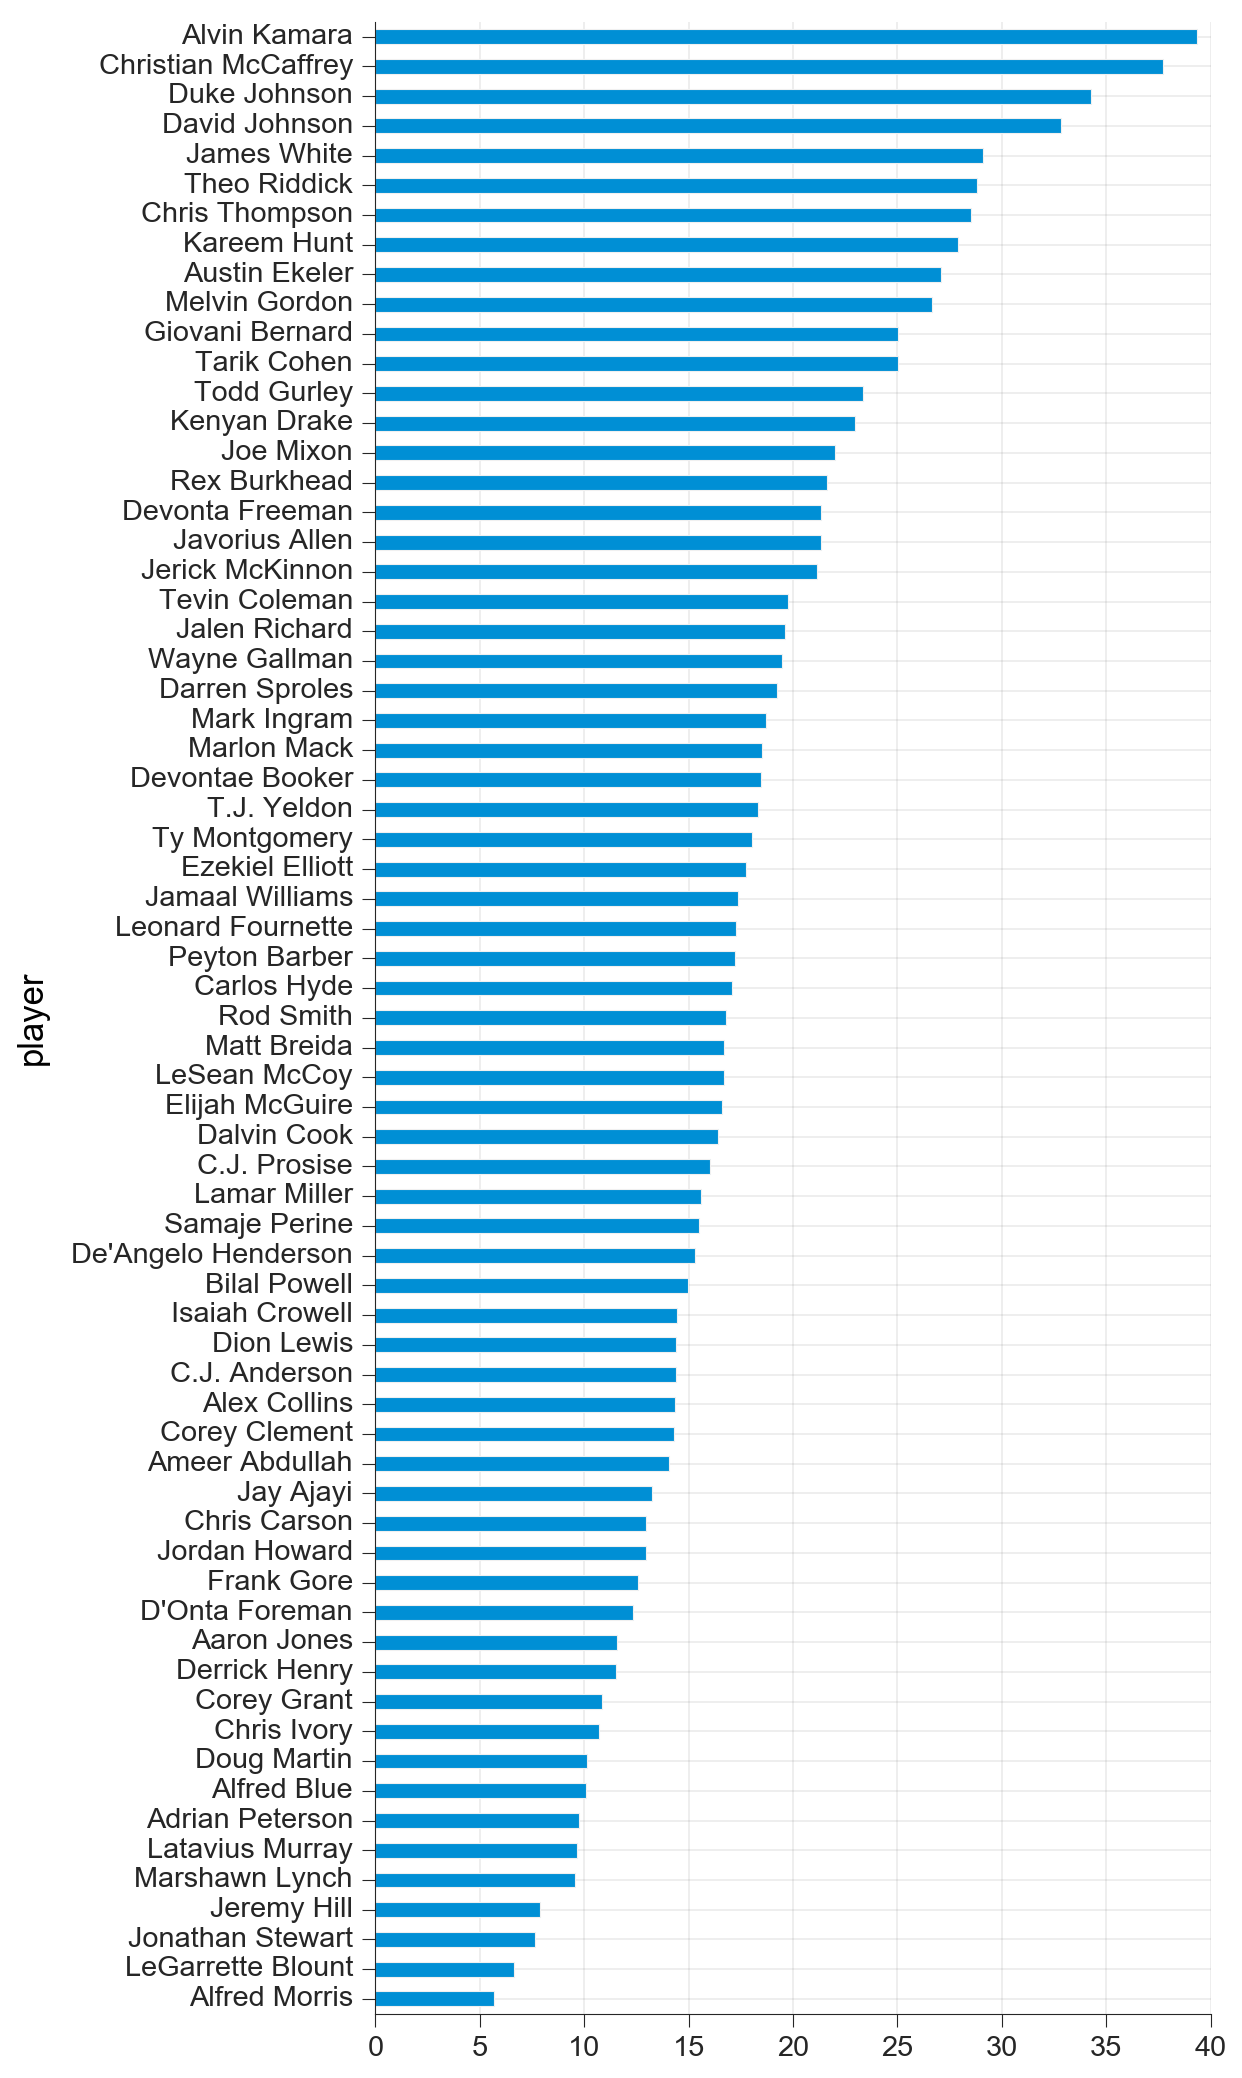

Running Models for rec_per_game
----------------------------------
Running VIF Feature Reduction
Training Ensemble Model
    lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
0  0.263  0.262  0.211  0.264  0.93  0.74    0.497   0.705   0.075  0.274
1  0.260  0.262  0.213  0.265  0.95  0.75    0.495   0.704   0.075  0.274
4  0.261  0.264  0.211  0.264  0.95  0.75    0.495   0.704   0.075  0.274
3  0.259  0.262  0.213  0.265  0.95  0.75    0.493   0.702   0.075  0.274
2  0.260  0.262  0.214  0.265  0.95  0.75    0.491   0.700   0.075  0.274


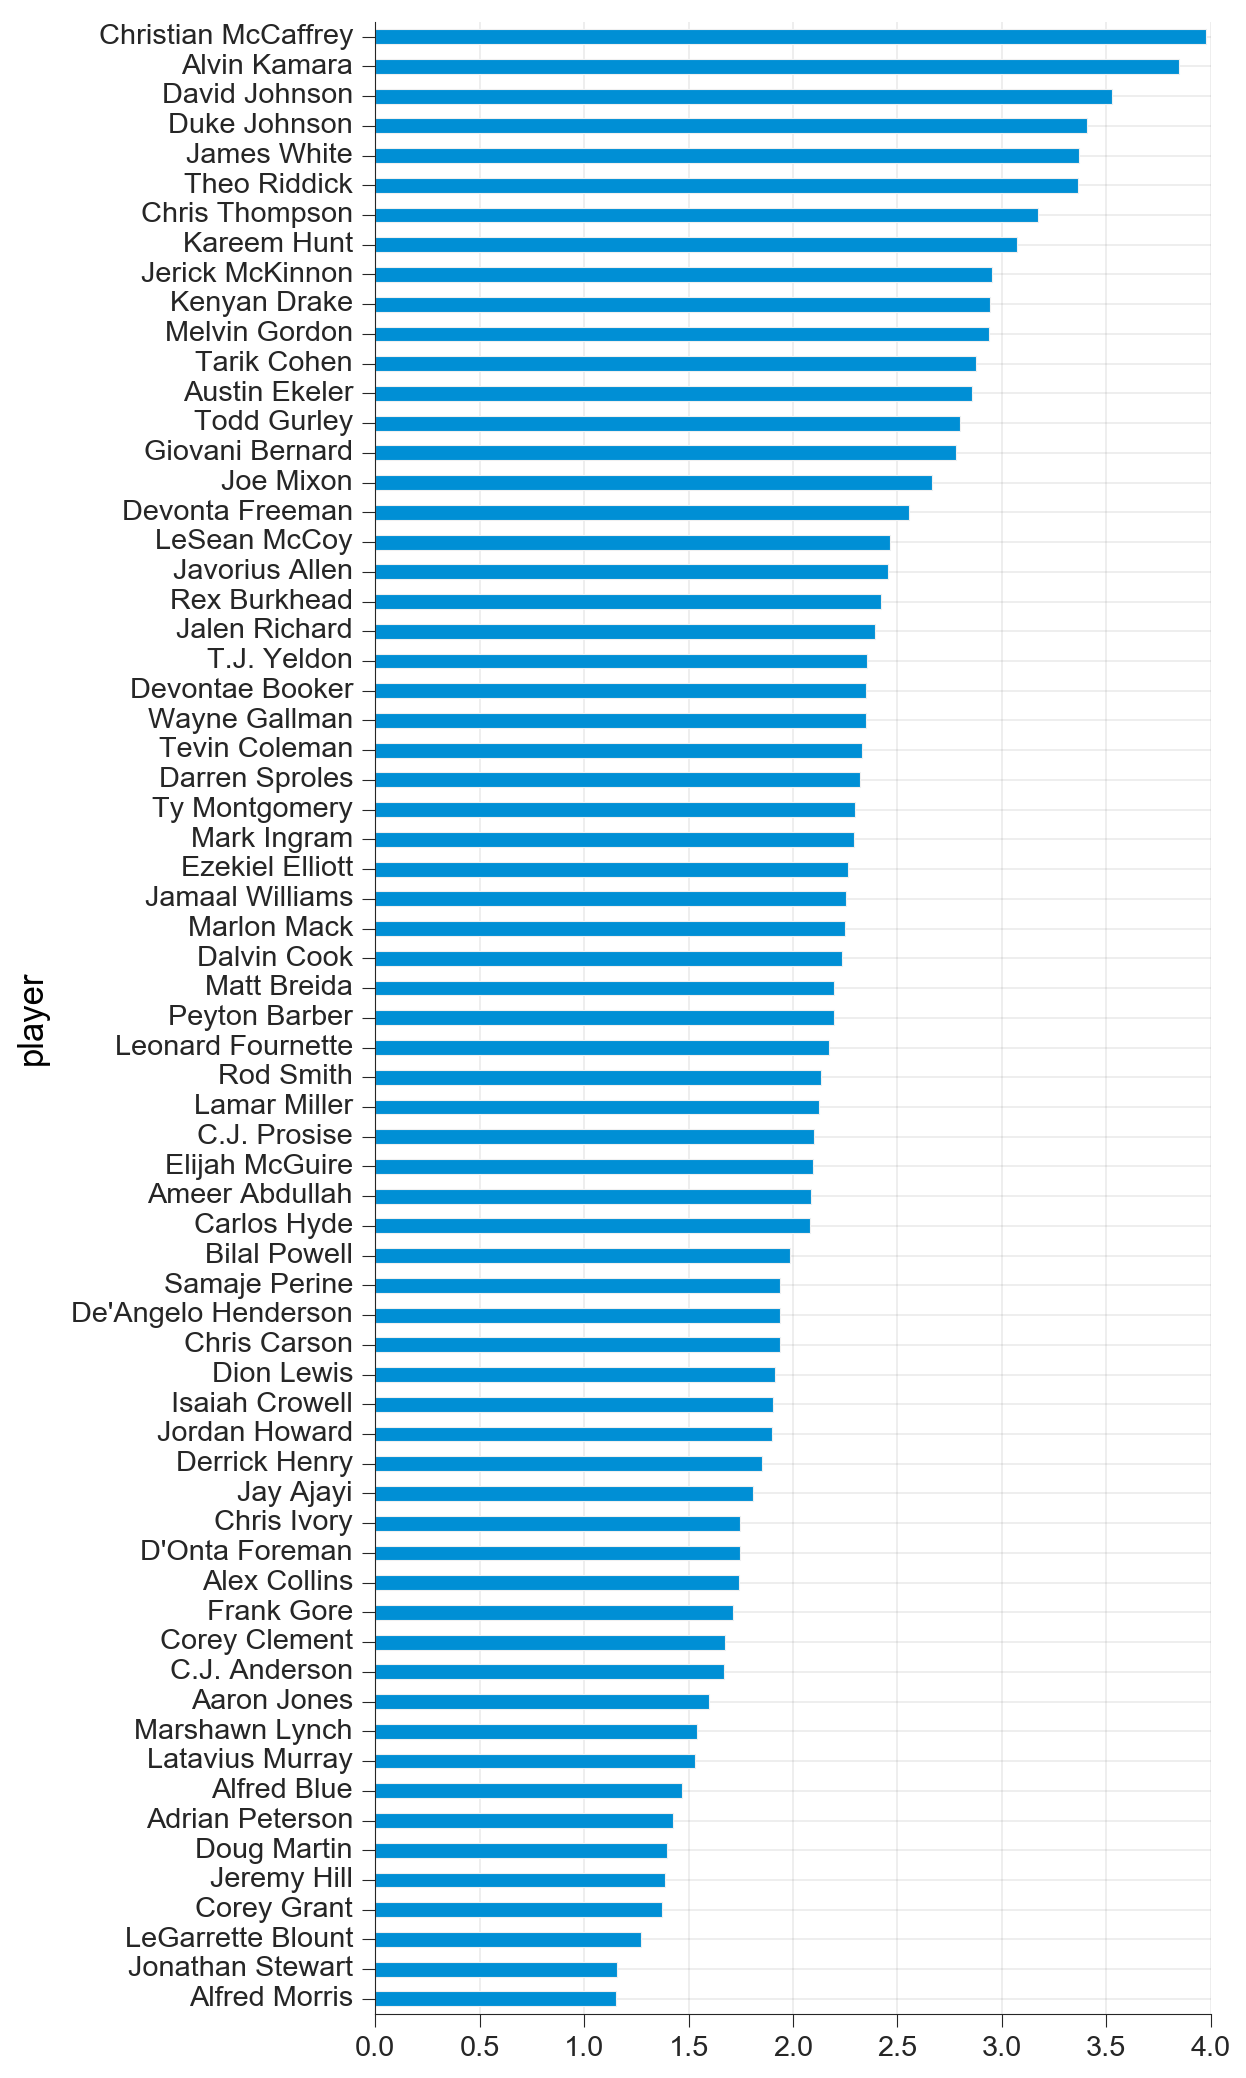

Running Models for td_per_game
----------------------------------
Running VIF Feature Reduction
Training Ensemble Model
    lgbm    xgb  lasso  ridge  rmse  mae  r2_pred  c_pred  r2_adp  c_adp
2  0.251  0.251  0.237  0.262  0.25  0.2    0.238   0.488   0.243  0.493
4  0.252  0.253  0.235  0.260  0.25  0.2    0.232   0.482   0.243  0.493
3  0.248  0.252  0.238  0.263  0.25  0.2    0.230   0.479   0.243  0.493
0  0.250  0.254  0.235  0.261  0.25  0.2    0.222   0.471   0.243  0.493
1  0.248  0.252  0.238  0.262  0.25  0.2    0.218   0.467   0.243  0.493


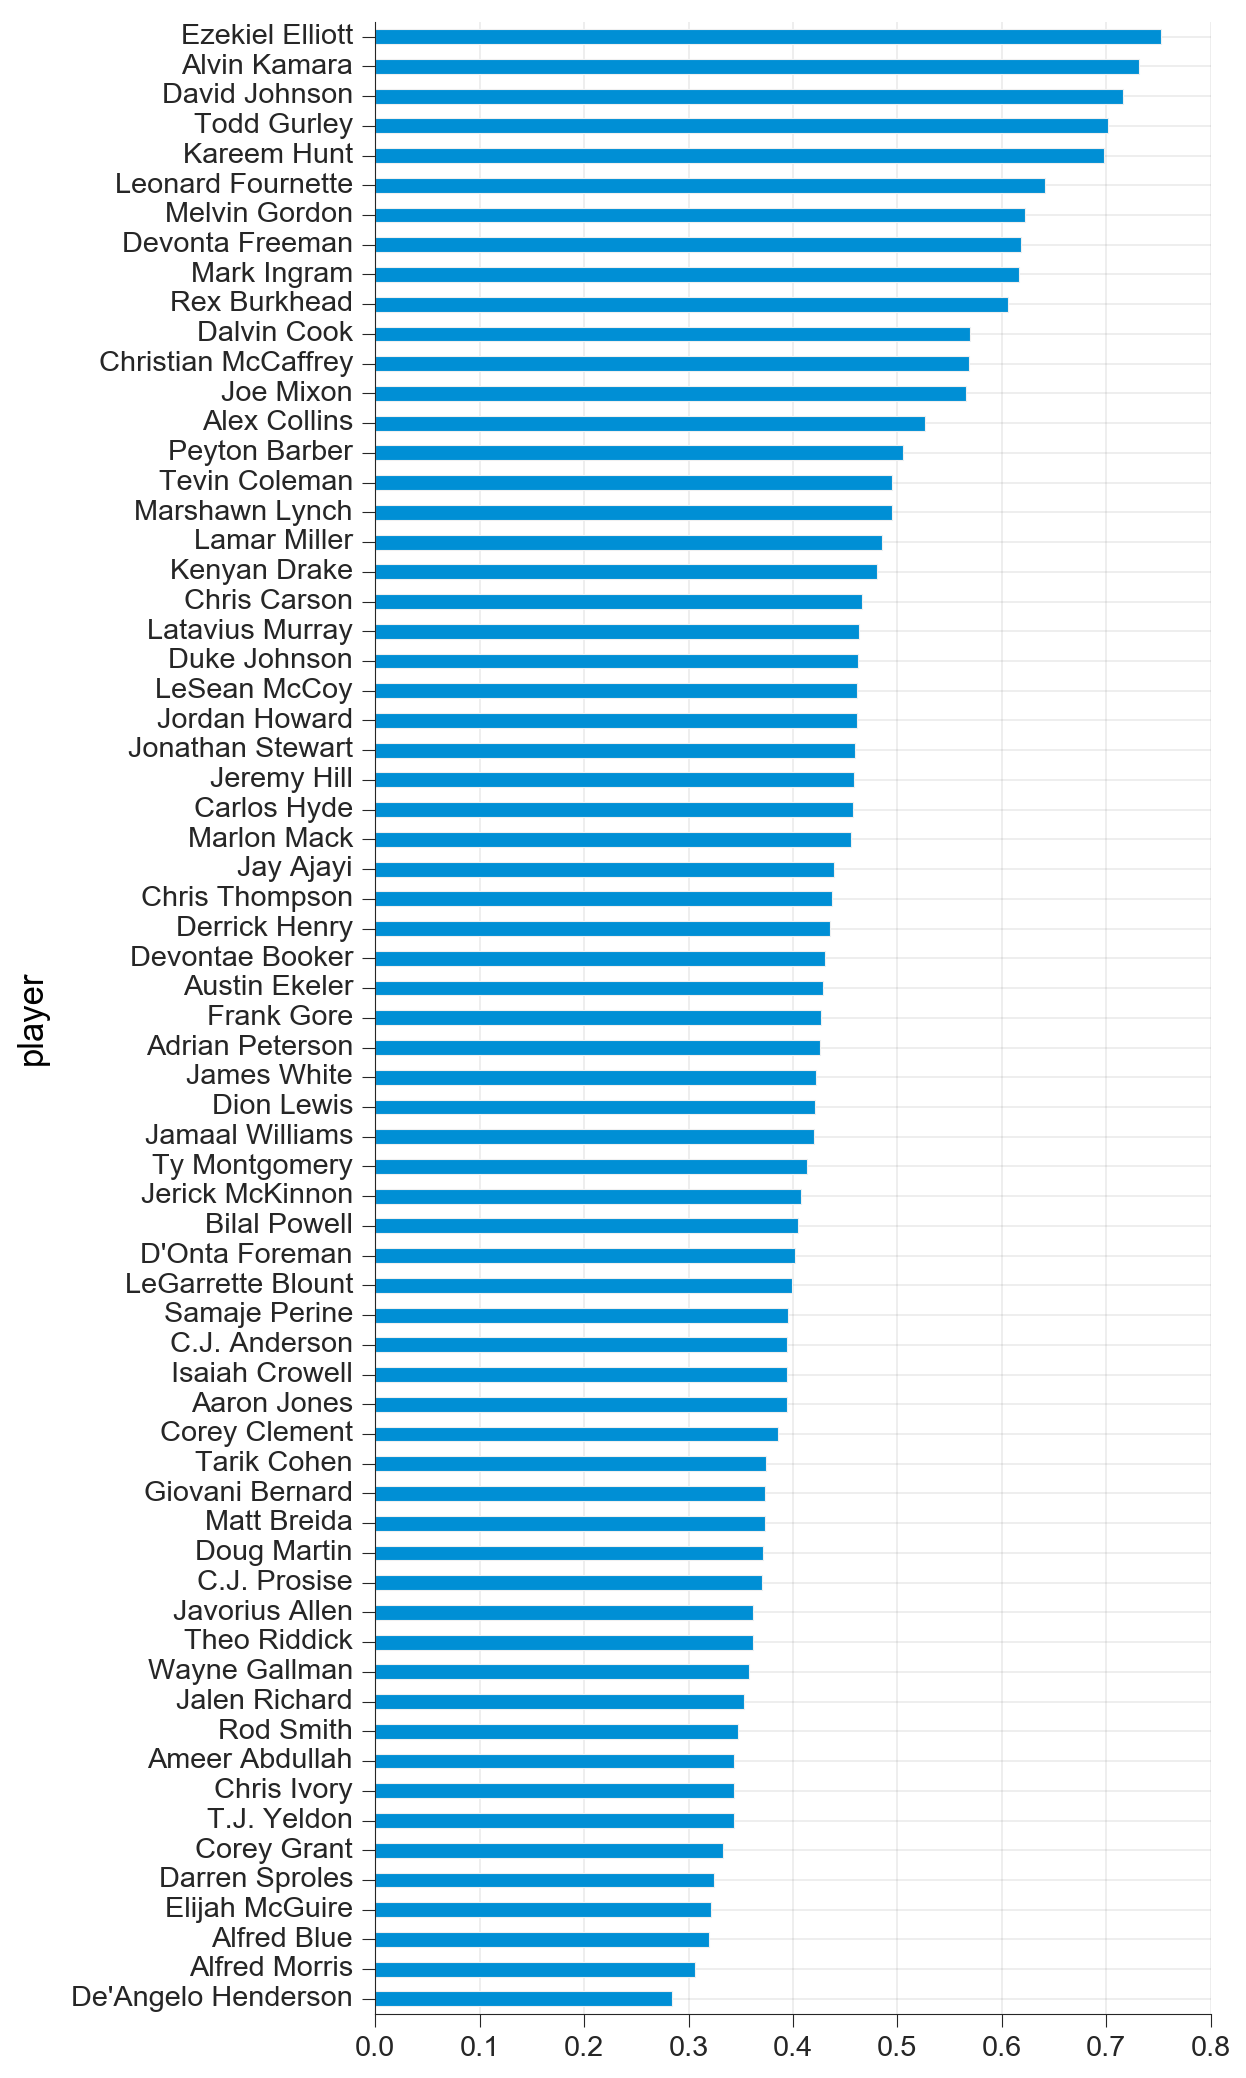

In [73]:
#==========
# Loop to create statistical predictions
#==========

output = {}

for metric in pos[set_pos]['metrics']:
    
    print('Running Models for ' + metric)
    print('----------------------------------')
    
    #--------
    # Create train and predict dataframes
    #--------
    df_train, df_predict = features_target(df, 
                                           earliest_year, set_year-1, 
                                           pos[set_pos]['med_features'], 
                                           pos[set_pos]['sum_features'],
                                           pos[set_pos]['max_features'], 
                                           pos[set_pos]['age_features'],
                                           target_feature=metric)

    df_train = df_train.dropna(subset=['y_act']).reset_index(drop=True)

    df_train = df_train.fillna(df_train.mean())
    df_predict = df_predict.dropna().reset_index(drop=True)

    #--------
    # Remove low correlation features and high VIF features
    #--------

    # remove low correlation features
    df_train, df_predict = corr_removal(df_train, df_predict, corr_cutoff=0.05)

    # select only features with low vif for modeling
    transformer = ReduceVIF(thresh=vif_thresh, scale=True, print_progress=False)
    df_train_ = transformer.fit_transform(df_train.drop(['y_act', 'player'], axis=1), df_train.y_act)

    # extract best columns and filter down df_predict
    best_cols = list(df_train_.columns)
    best_cols.extend(['player', 'avg_pick'])
    df_predict = df_predict[best_cols]
    df_predict = df_predict.loc[:,~df_predict.columns.duplicated()]

    # add target and filter down df_train
    best_cols.extend(['y_act', 'year', 'avg_pick'])
    df_train = df_train[best_cols]
    df_train = df_train.loc[:,~df_train.columns.duplicated()]

    #--------
    # Run ensemble model with parameter optimization
    #--------

    # generate a master dictionary of parameters (must match the)
    param_list = [lgbm_params, xgb_params, lasso_params, ridge_params]
    est_names = ['lgbm', 'xgb', 'lasso', 'ridge']

    params = {}
    for i, param in enumerate(param_list):
        params[est_names[i]] = param
    
    print('Training Ensemble Model')
    param_results, summary, df_train_results_, errors = validation(est_names, params, df_train, iterations=iter_rounds, random_state=1234)
    
    #--------
    # Print best results
    #--------
    
    # print a summary of error metrics, weightings of various models, and a comparison to 
    # using straight adp as as a prediction for next year's stats
    print(summary.head(10))
    
    # pull out the best result for the random hyperparameter search of models
    best_result = summary.index[0]
    
    # pass the best hyperparameters into the generation_prediction function, which
    # will return the test results for the current year and the trained best models
    df_test_results_, models = generate_predictions(best_result, param_results, summary, df_train, df_predict)
    
    #--------
    # Aggregate all results through merging
    #--------
    
    # add models to output dictionary
    output[metric] = {}
    output[metric]['models'] = models
    
    # add params to output dictionary
    output[metric]['params'] = param_results
    
    # add columns to output dictionary
    cols = list(df_train.columns)
    cols.remove('y_act')
    cols.remove('player')
    output[metric]['cols'] = cols
    
    # merge the train results for the given metric with all other metric outputs
    df_train_results_ = df_train_results_.rename(columns={'pred': 'pred_' + metric})
    df_train_results = pd.merge(df_train_results, df_train_results_[['player', 'year','pred_' + metric]], 
                                how='inner', left_on=['player', 'year'], right_on=['player', 'year'])
    
    # merge the test results for the given metric with all other metric outputs
    df_test_results_ = df_test_results_.rename(columns={'pred': 'pred_' + metric})
    df_test_results = pd.merge(df_test_results, df_test_results_[['player', 'pred_' + metric]], 
                               how='inner', left_on='player', right_on='player')
    
# after loop, set the df_train to have the y_act as fp_per_game
df_train, df_predict = features_target(df, earliest_year, set_year-1, 
                                           pos[set_pos]['med_features'], 
                                           pos[set_pos]['sum_features'],
                                           pos[set_pos]['max_features'], 
                                           pos[set_pos]['age_features'],
                                           target_feature='fp_per_game')

In [77]:
#==========
# If desired, plot feature importances for a given metric / model
#==========

if plot_importance == True:
    
    metric = 'rush_yd_per_game'
    i = 0
    try:
        plot_results(output[metric]['models'][i].feature_importances_, col_names=output[metric]['cols']);
    except:
        plot_results(output[metric]['models'][i].coef_, col_names=output[metric]['cols']);

In [ ]:
#==========
# Calculate fantasy points based on predictions and point values
#==========

df_train_results, df_test_results = format_results(df_train_results, df_test_results, 
                                                   df_train, df_predict, pts_list)

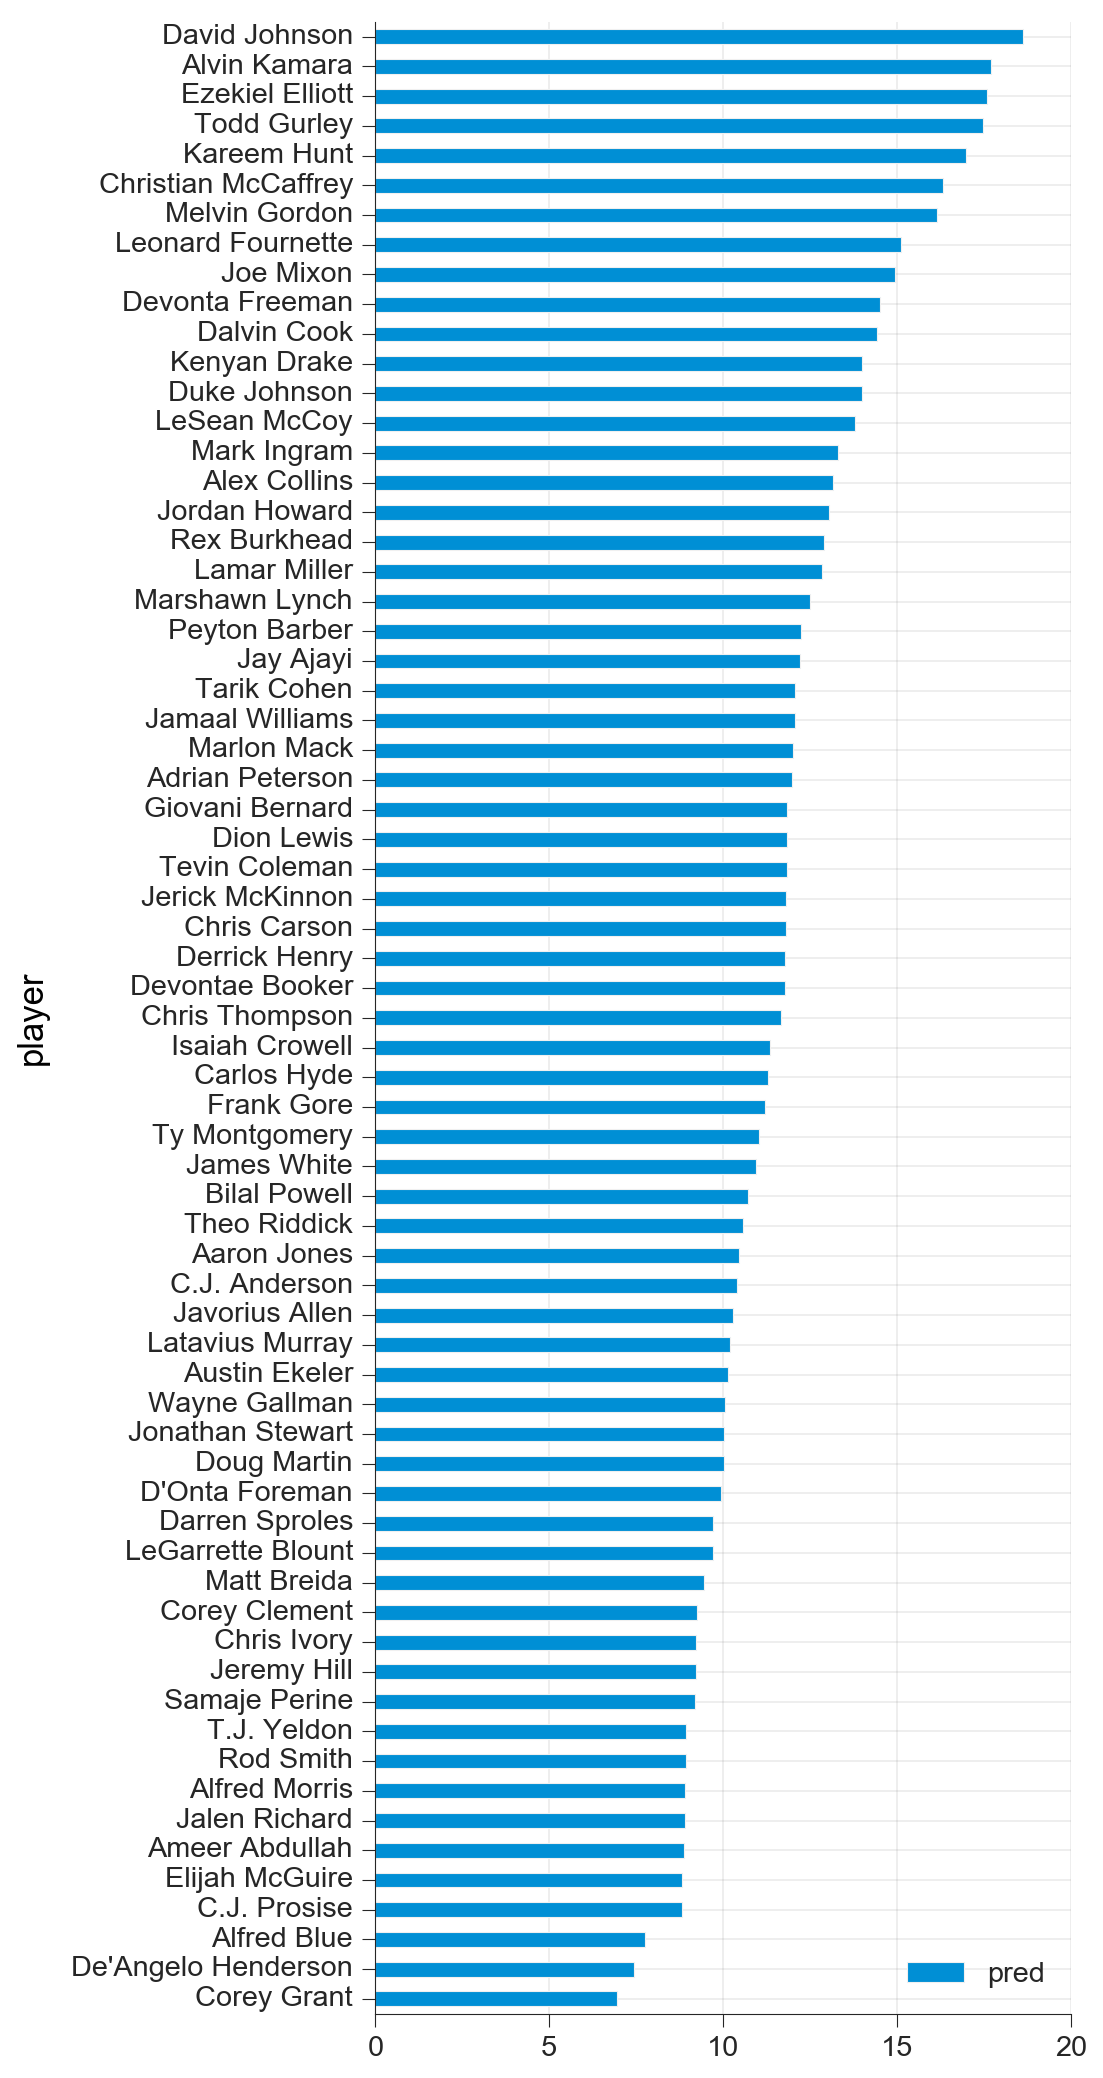

In [79]:
#==========
# Plot Predictions for Each Player
#==========

df_test_results.sort_values('pred').plot.barh(x='player', y='pred', figsize=(5,15));

# Clustering Players into Tiers

In [80]:
#==========
# Group Players into Clusters Using Decision Tree
#==========

# initialize cluster with train and test results
cluster = clustering(df_train_results, df_test_results)

# fit decision tree and apply nodes to players
cluster.fit_and_predict_tree()

# add linear regression of predicted vs actual for cluster predictions
c_train, c_test = cluster.add_fit_metrics()

Best RMSE:  3.624
Cluster List:  [4, 9, 5, 10, 8, 3]


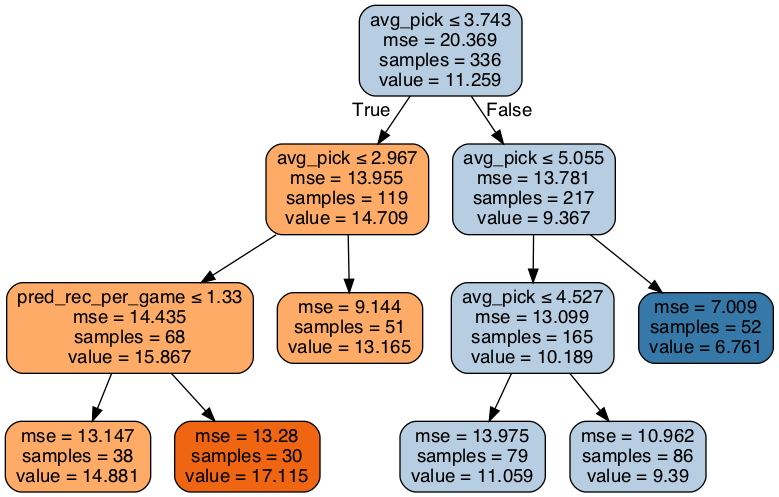

In [81]:
#==========
# Create Graph of Decision Tree Logic
#==========

cluster.tree_plot()

#==========
# Show the Results for Each Cluster
#==========

cluster.show_results(j=28)

David Johnson


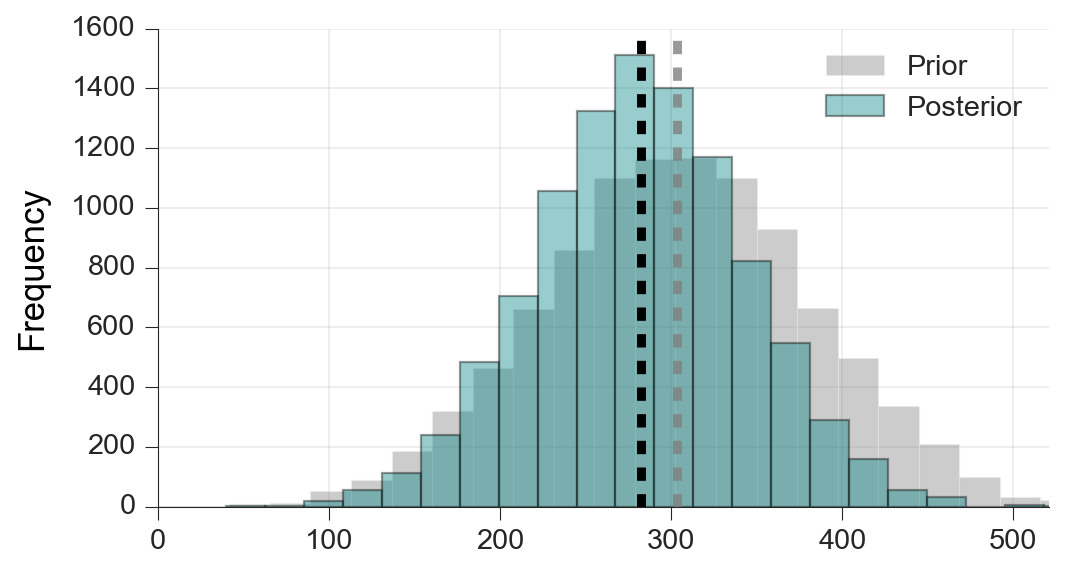

Alvin Kamara


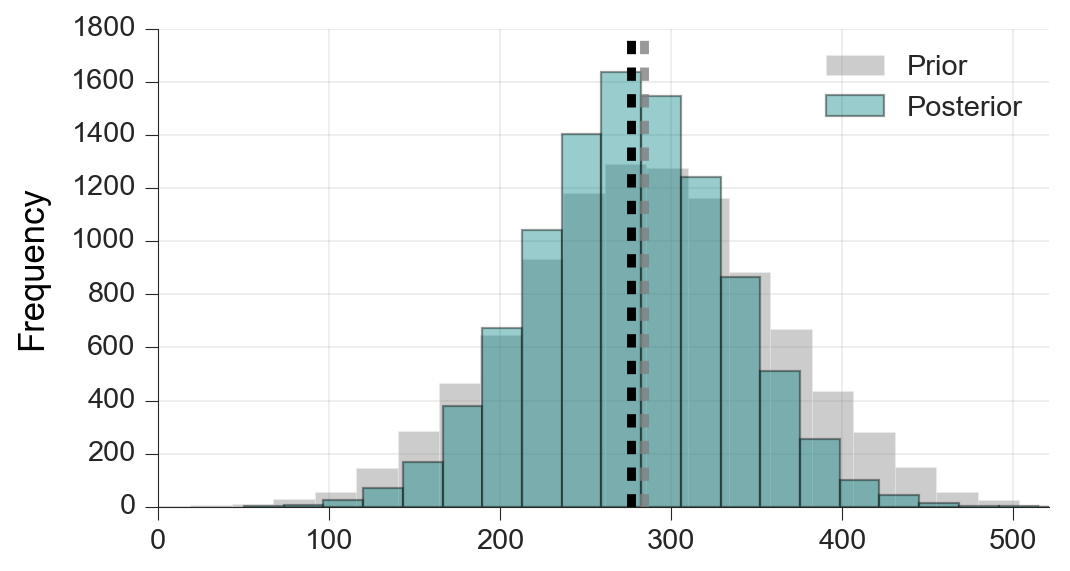

Ezekiel Elliott


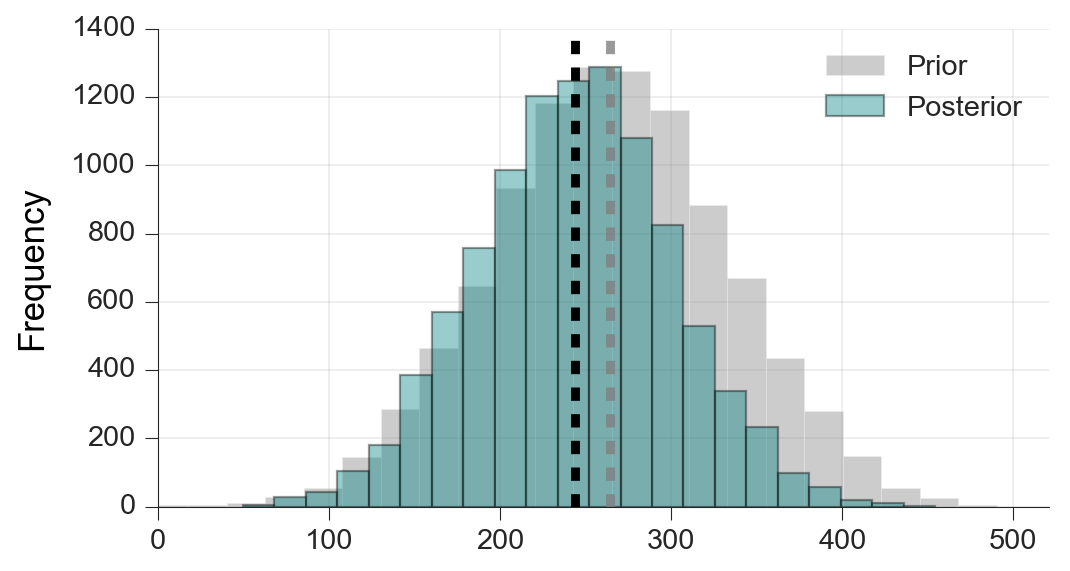

Todd Gurley


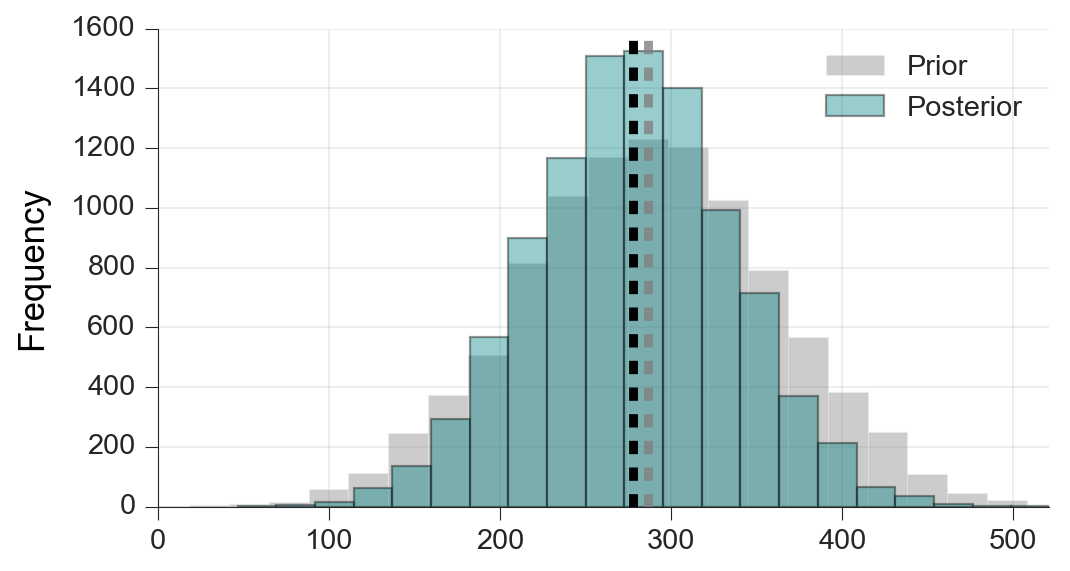

Kareem Hunt


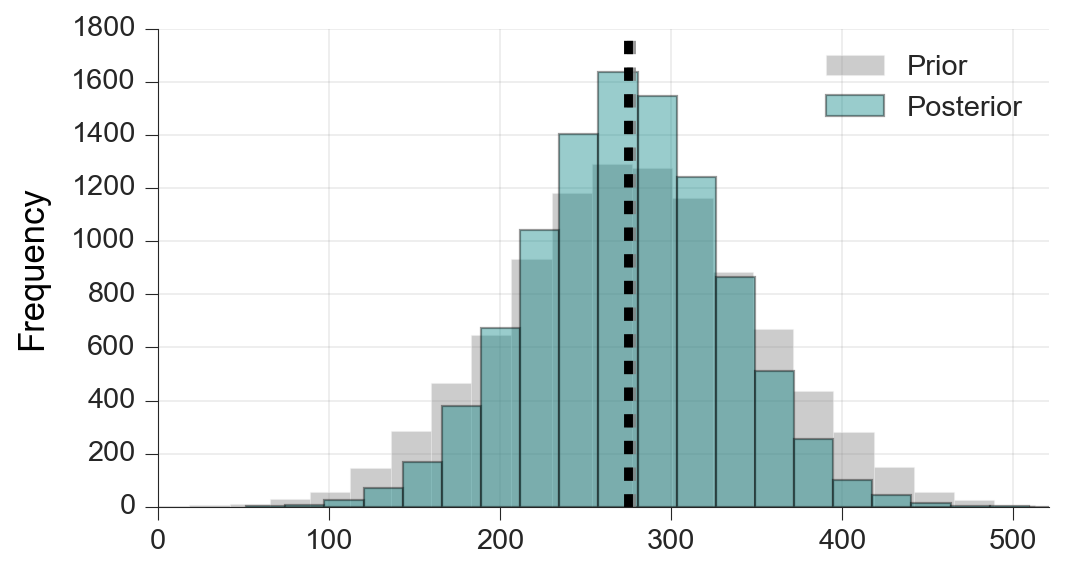

Christian McCaffrey


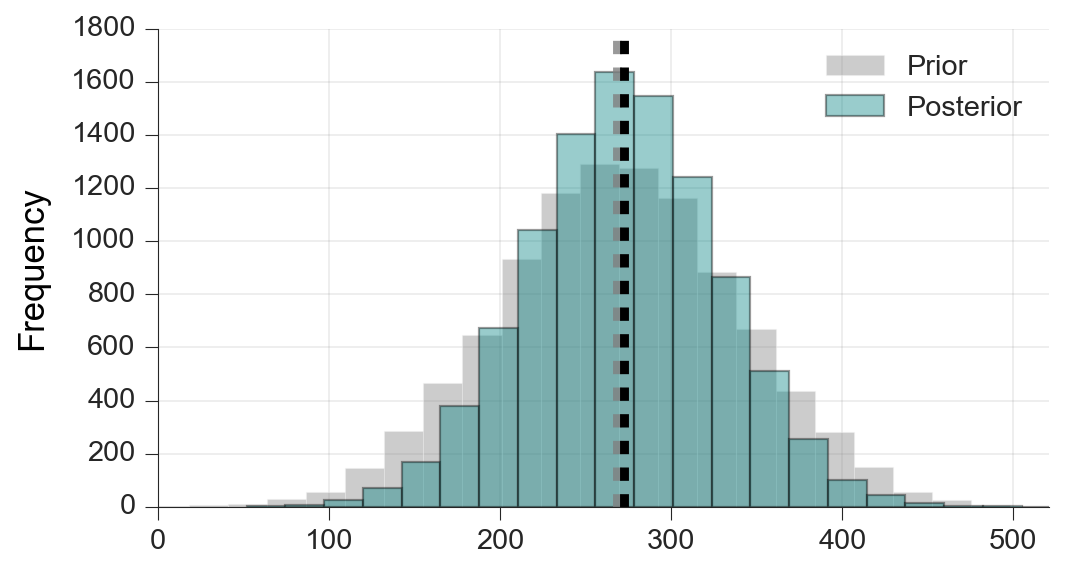

Melvin Gordon


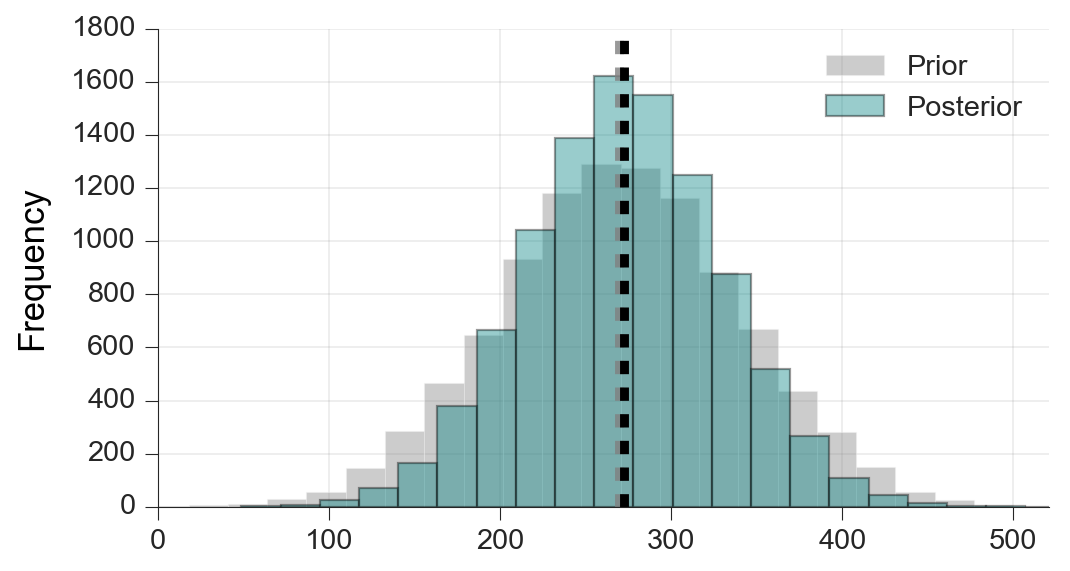

Leonard Fournette


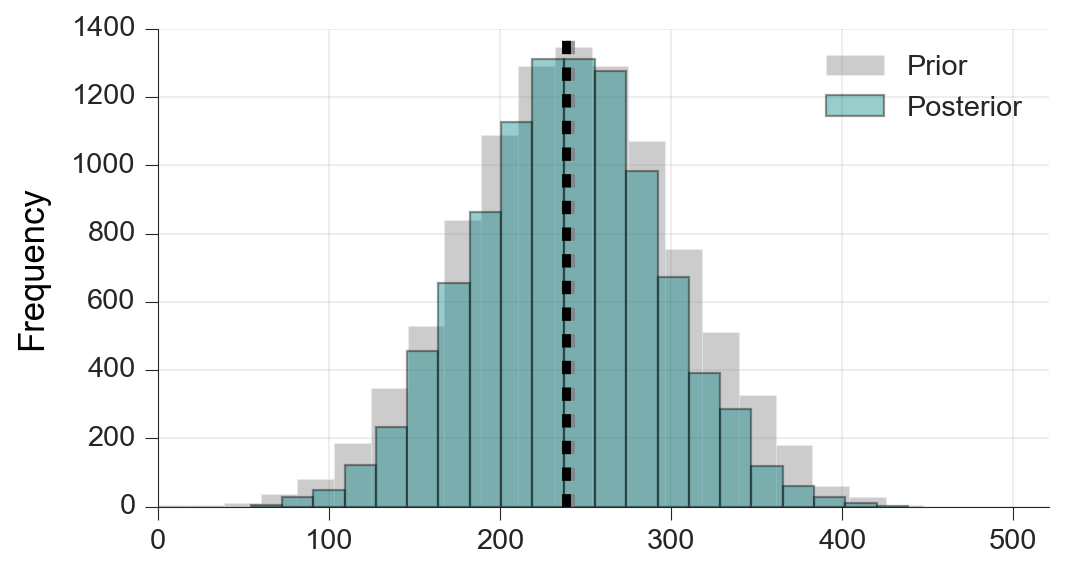

Joe Mixon


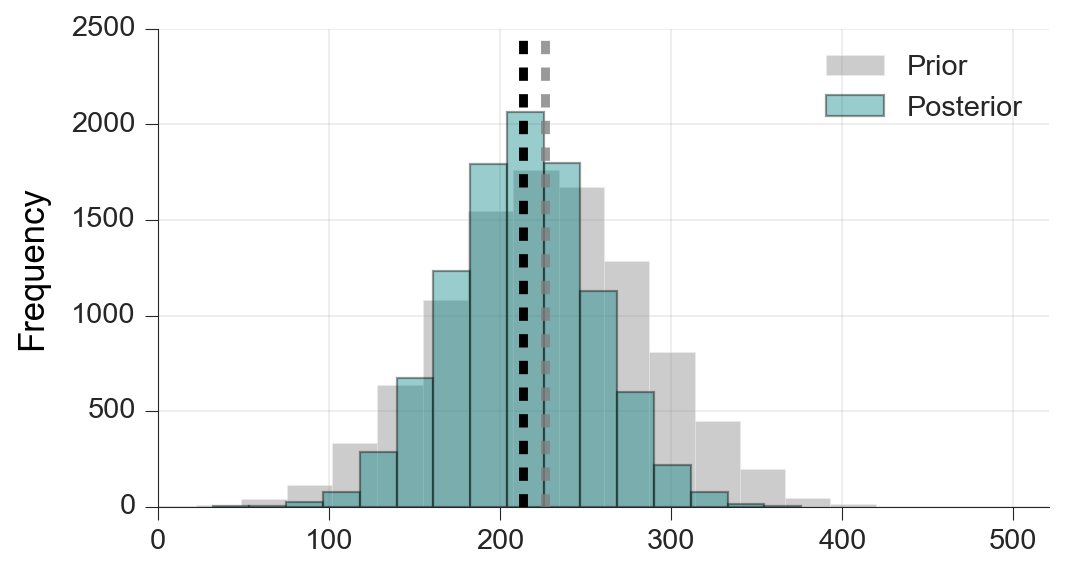

Devonta Freeman


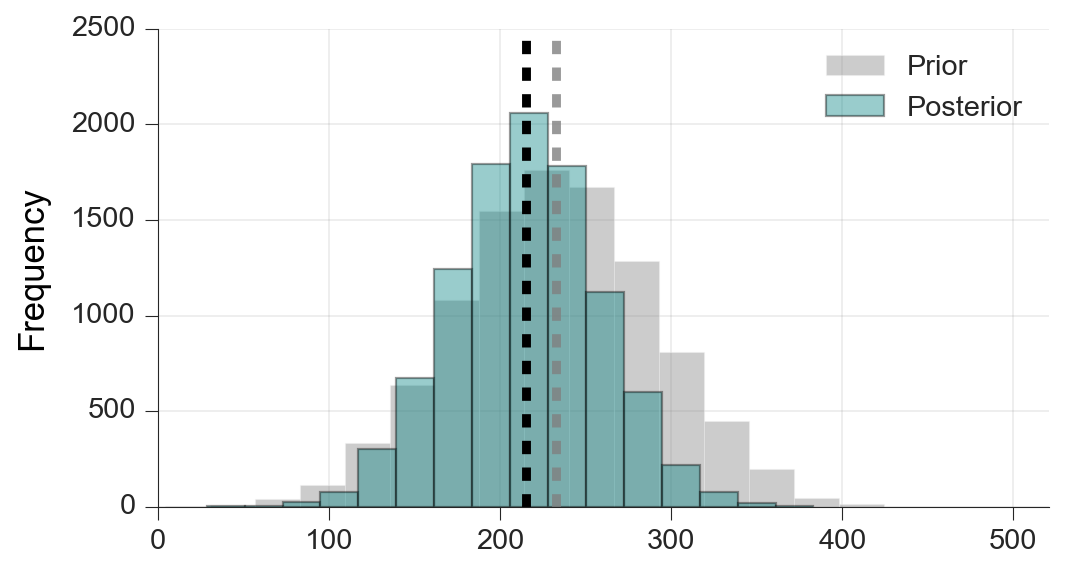

Dalvin Cook


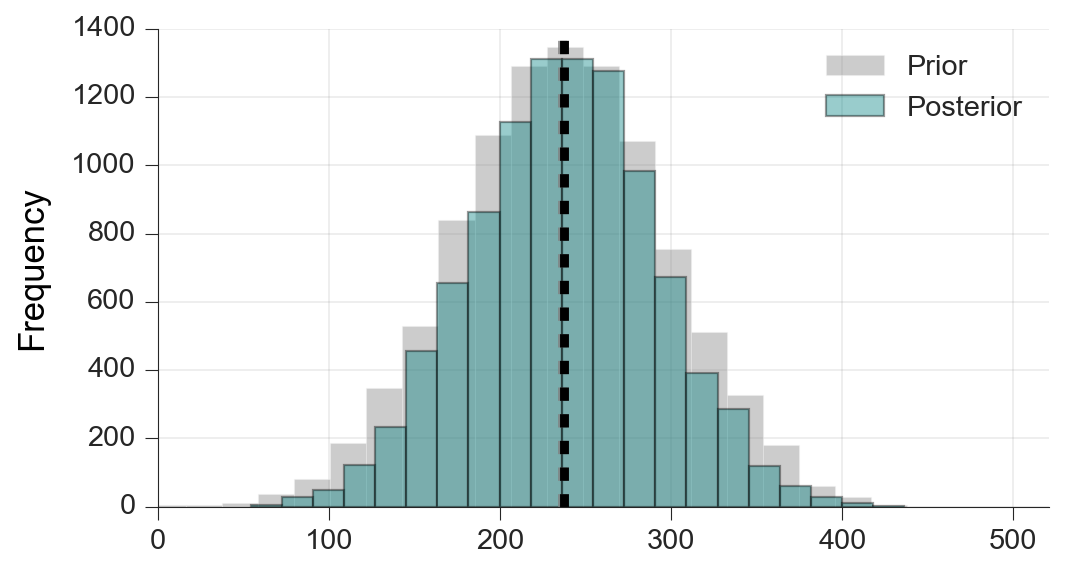

Kenyan Drake


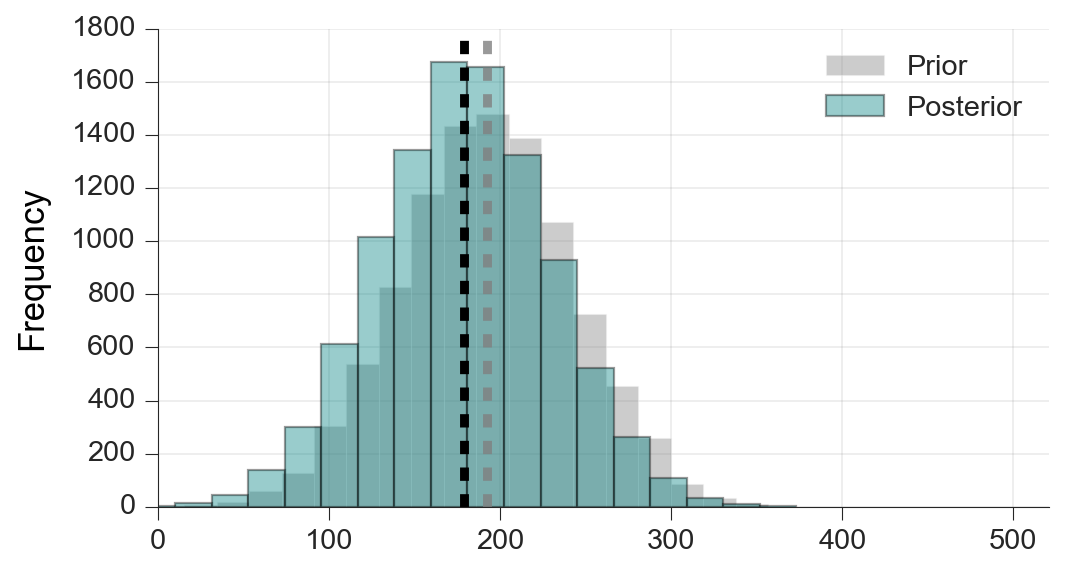

Duke Johnson


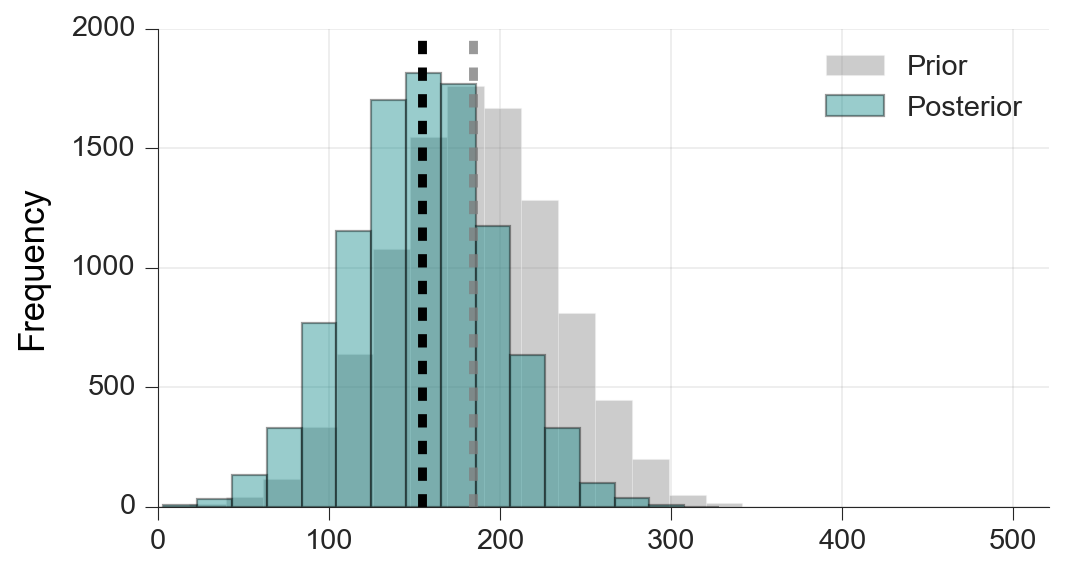

LeSean McCoy


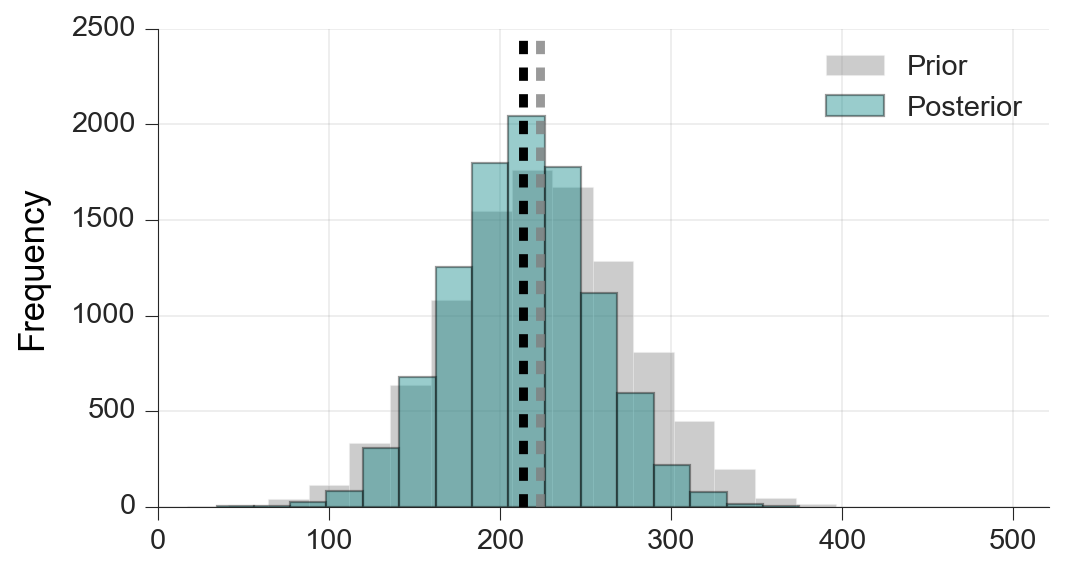

Mark Ingram


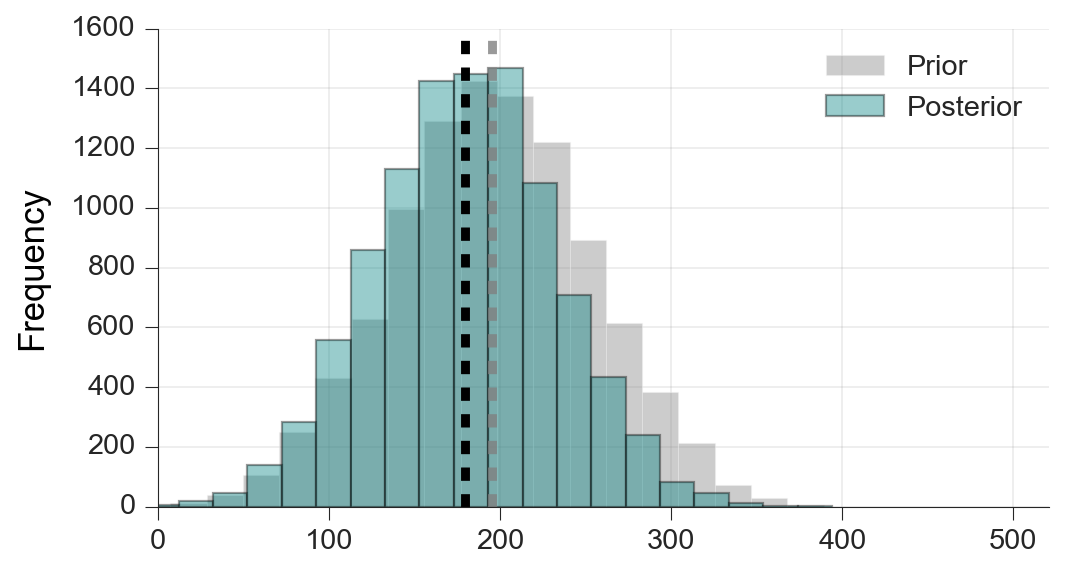

Alex Collins


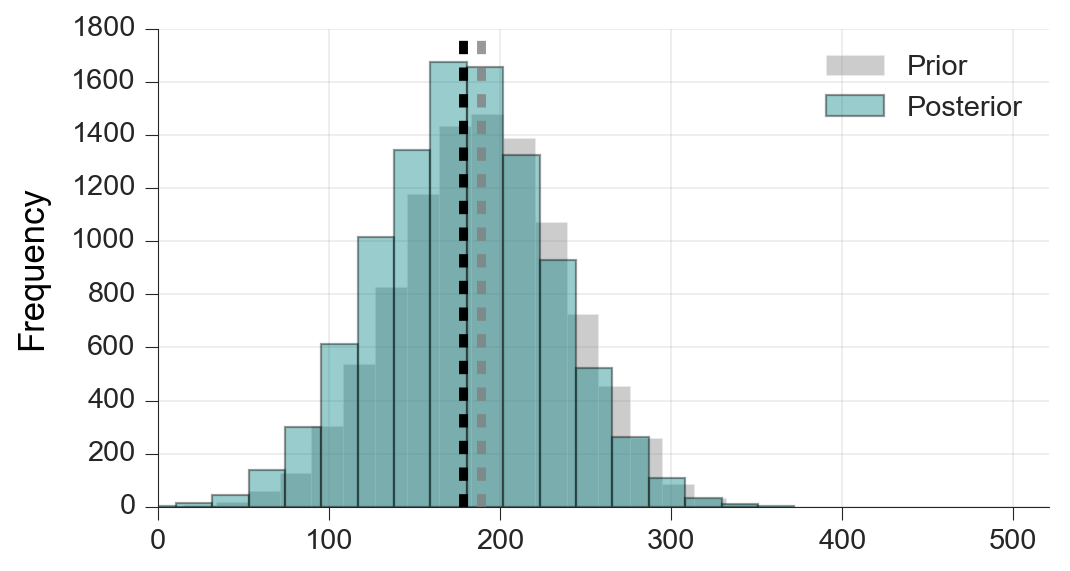

Jordan Howard


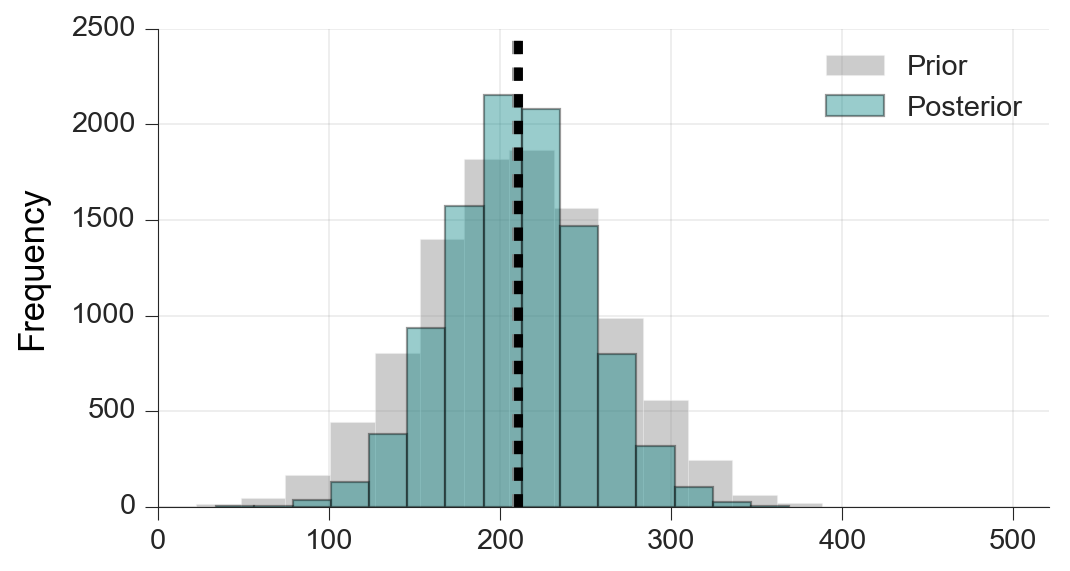

Rex Burkhead


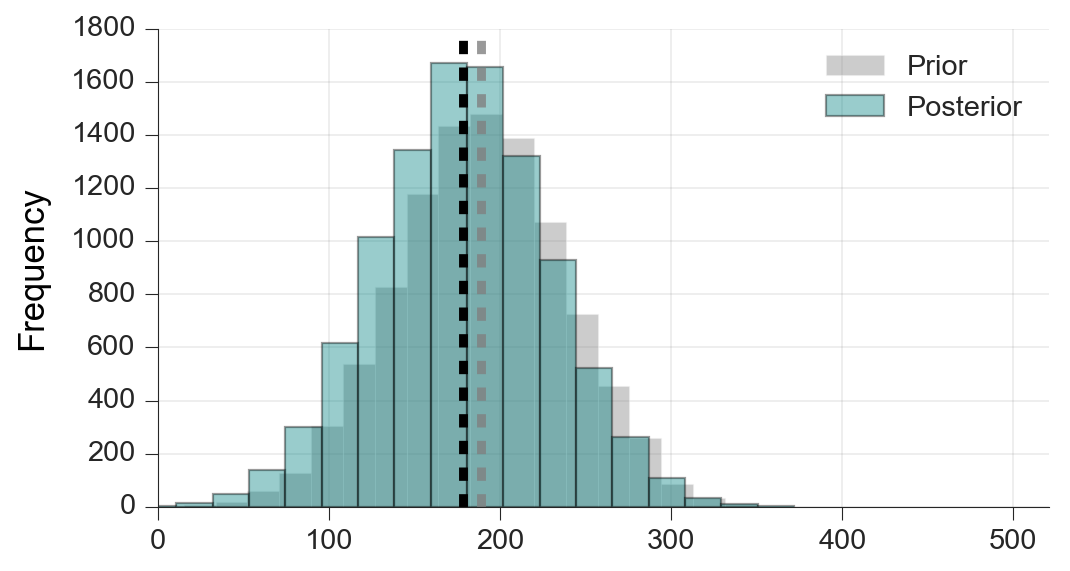

Lamar Miller


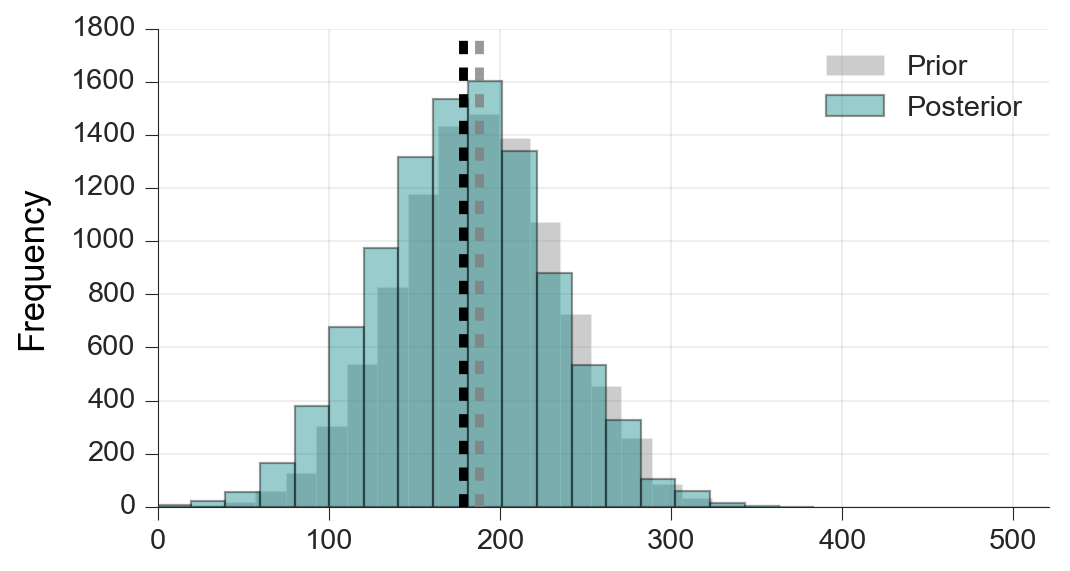

Marshawn Lynch


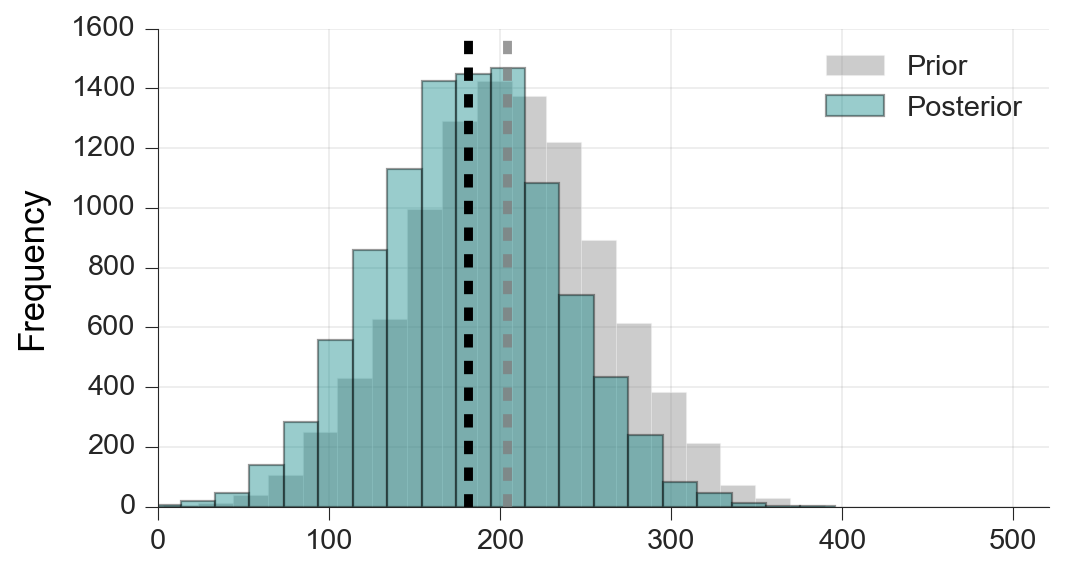

Peyton Barber


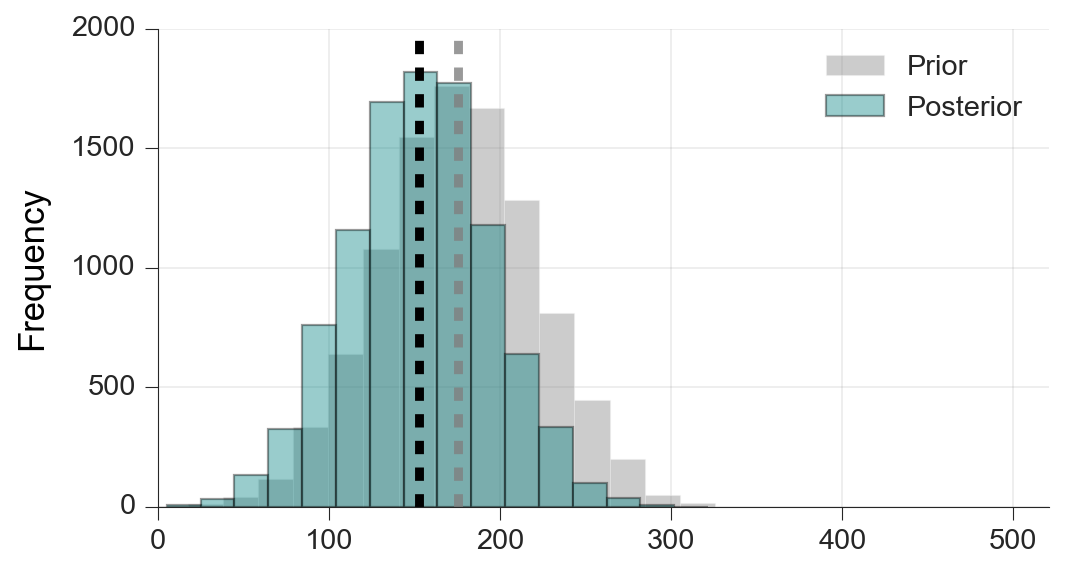

Jay Ajayi


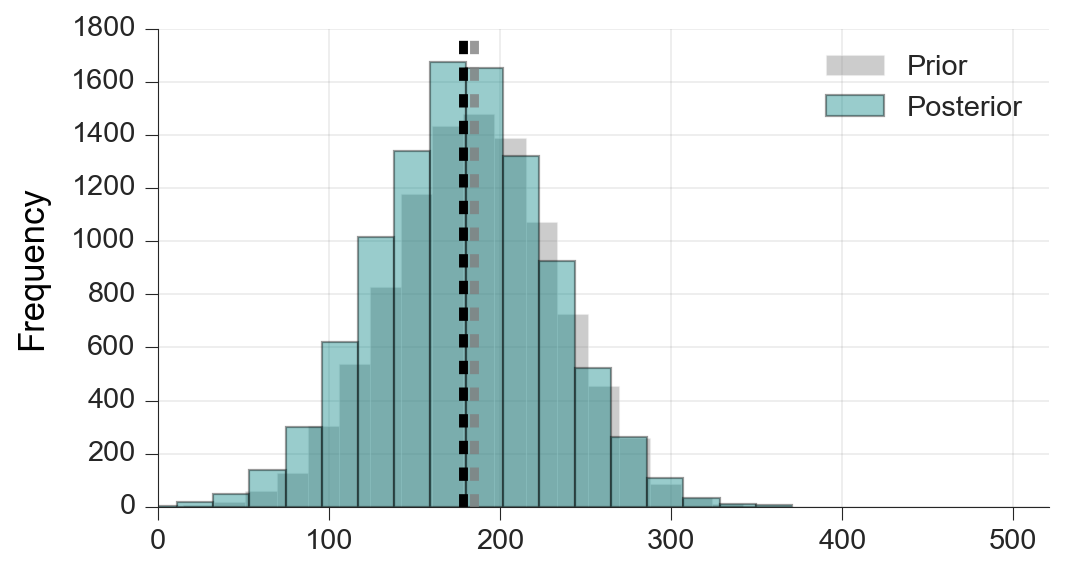

Tarik Cohen


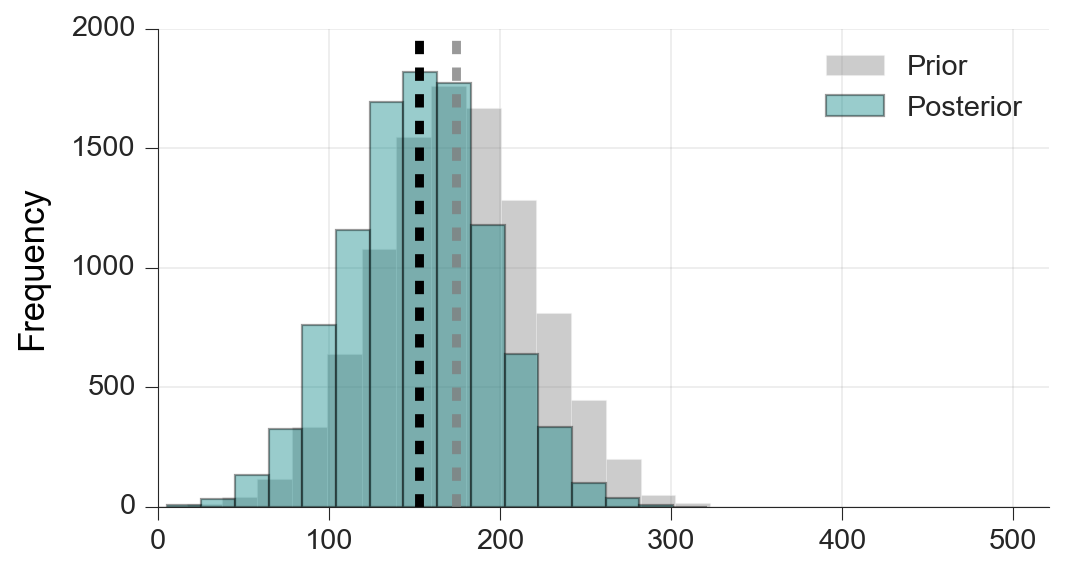

Jamaal Williams


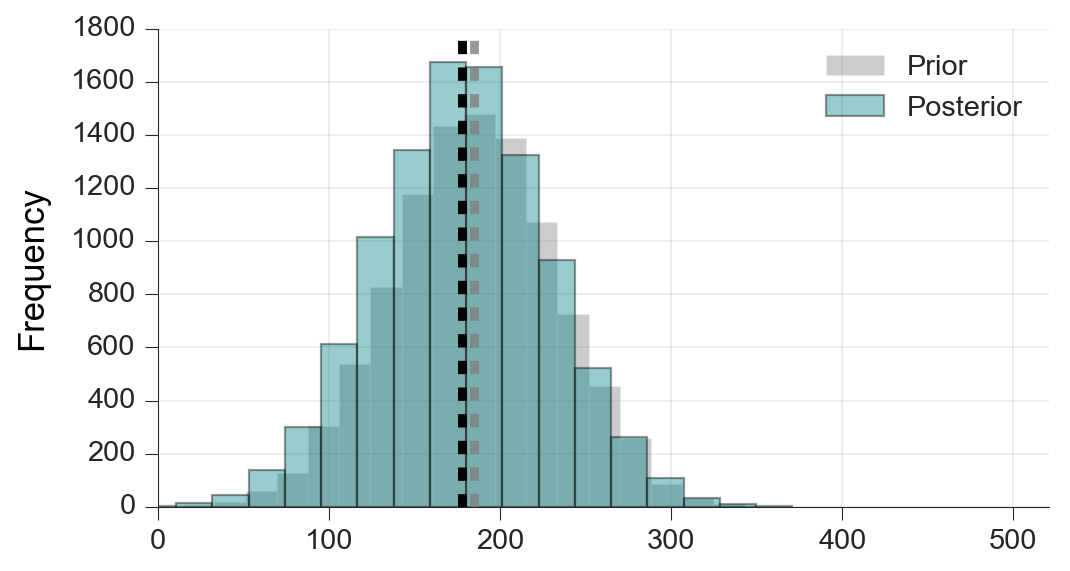

Marlon Mack


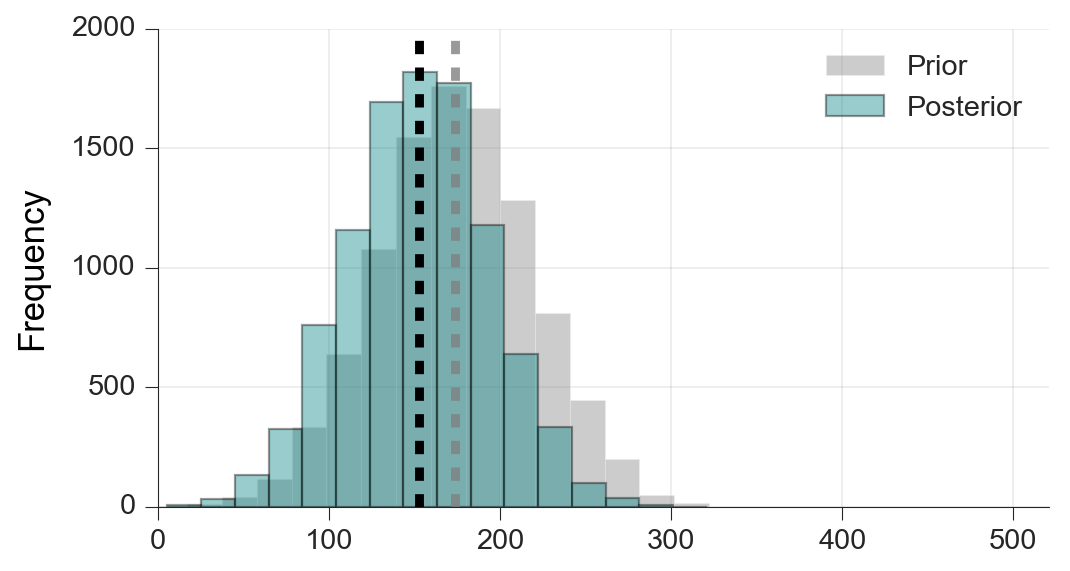

Adrian Peterson


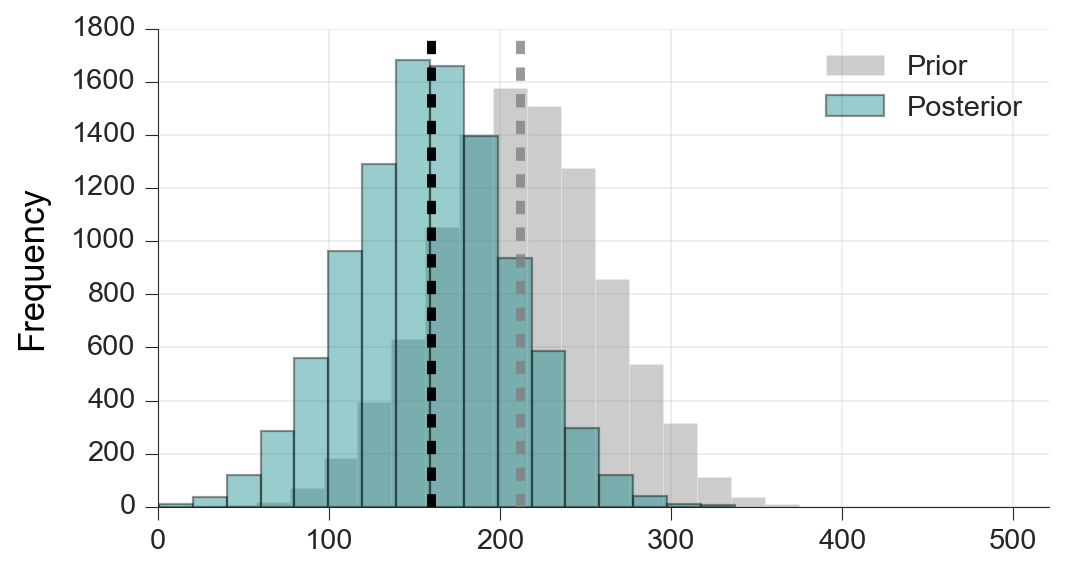

Giovani Bernard


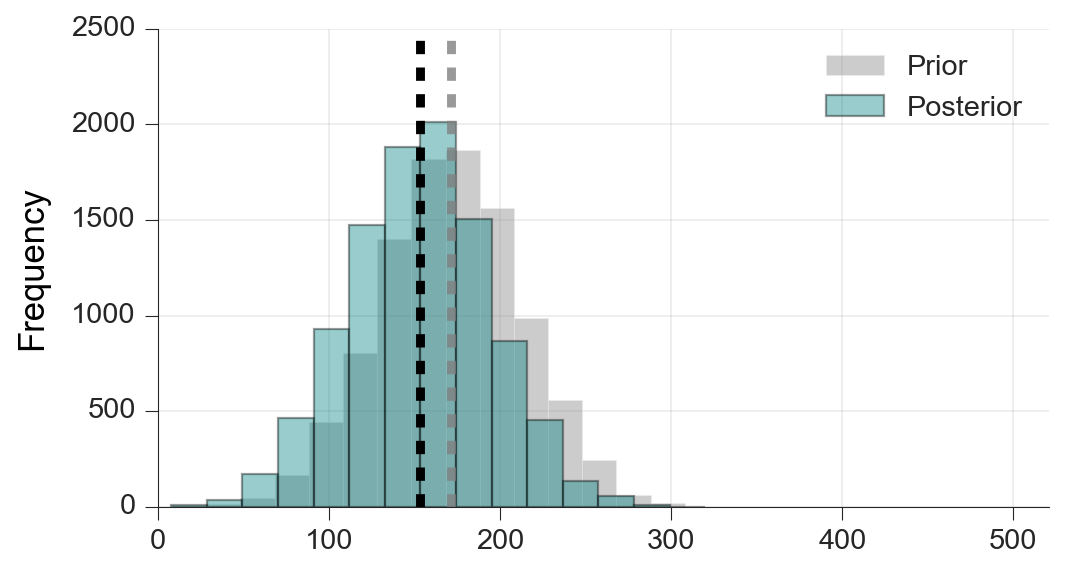

Dion Lewis


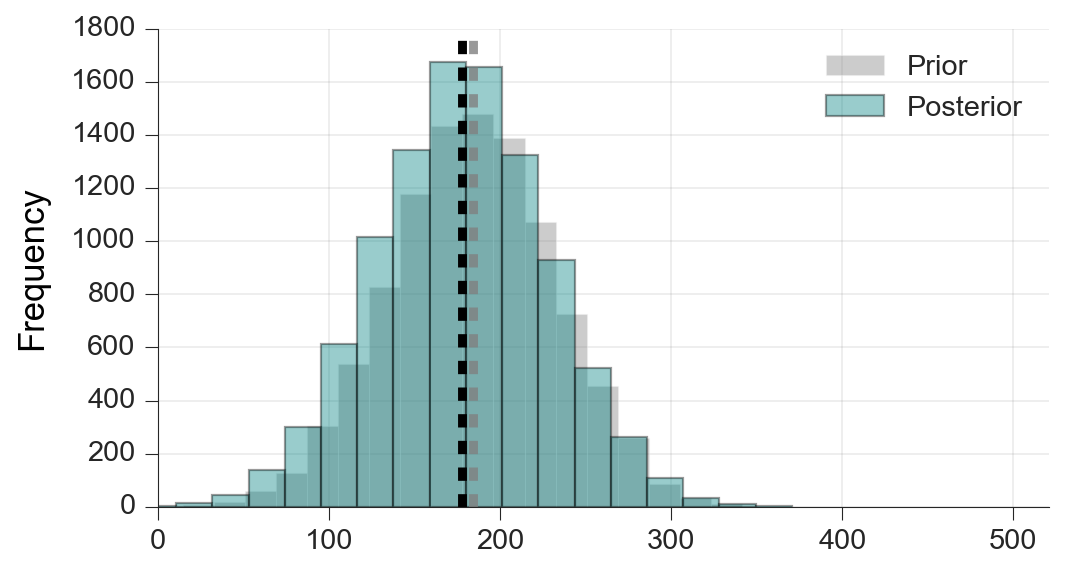

Tevin Coleman


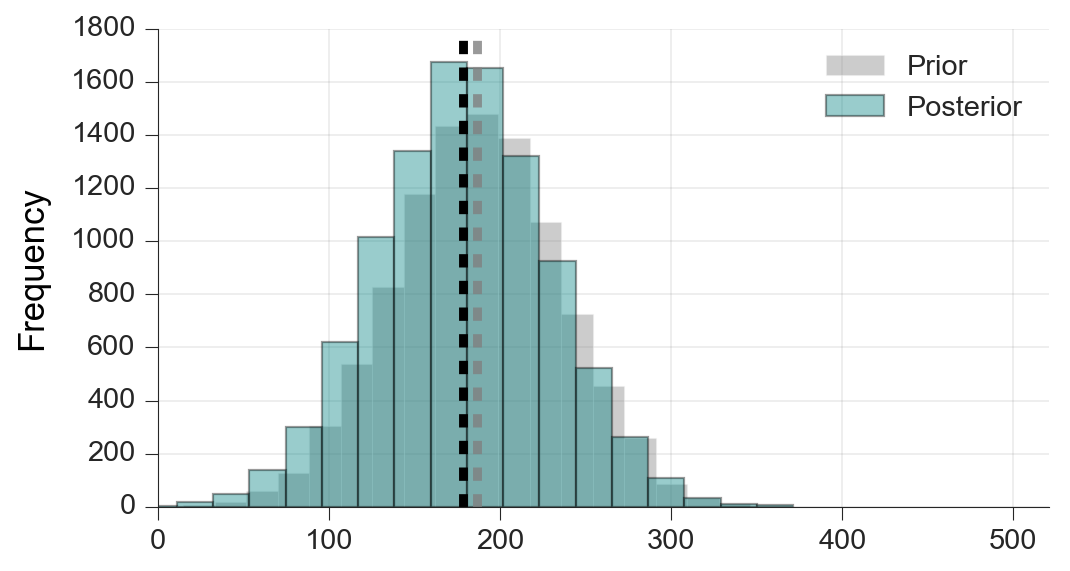

Jerick McKinnon


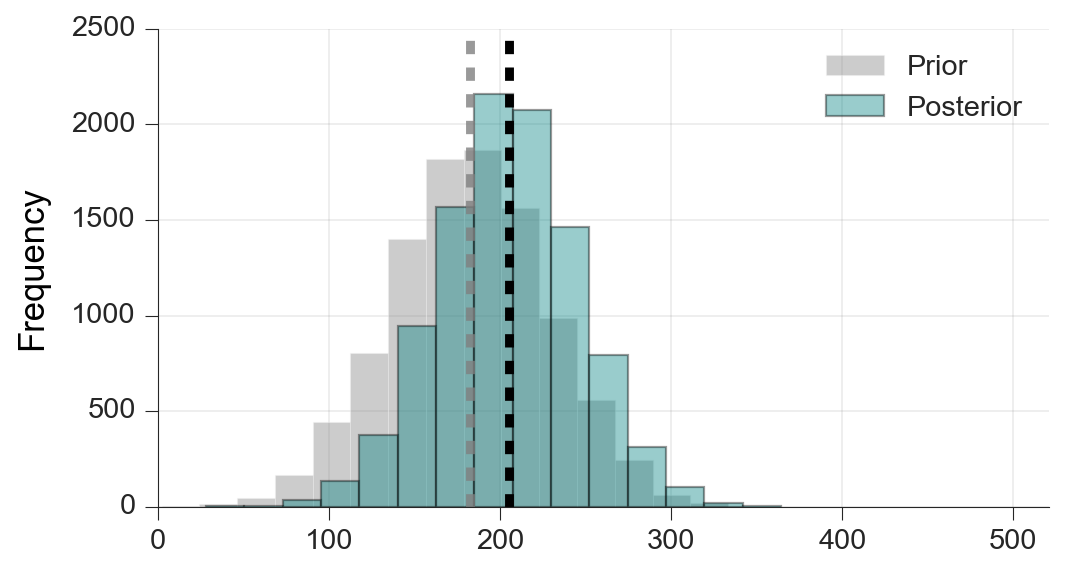

Chris Carson


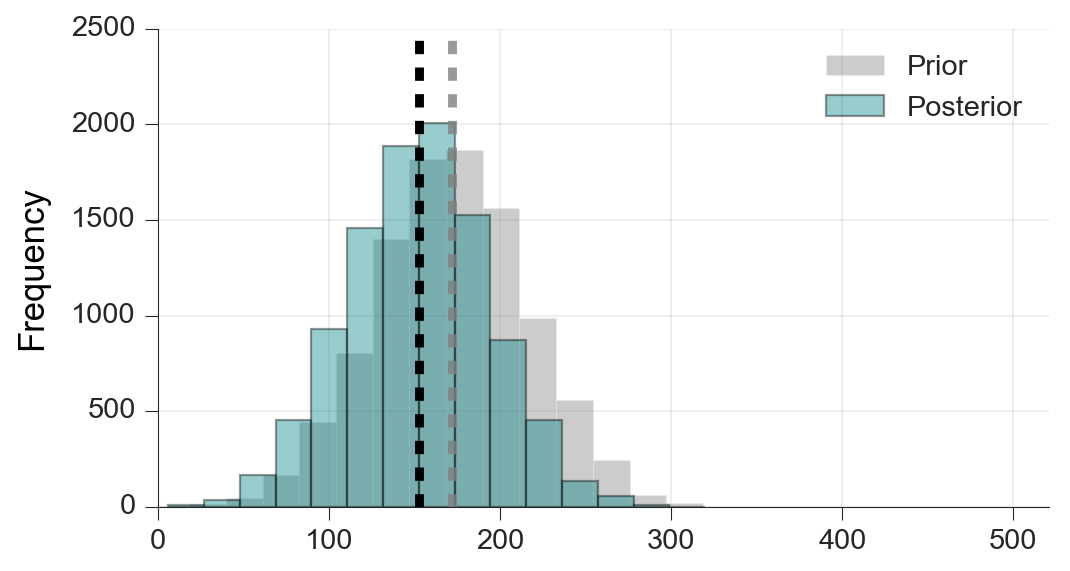

Derrick Henry


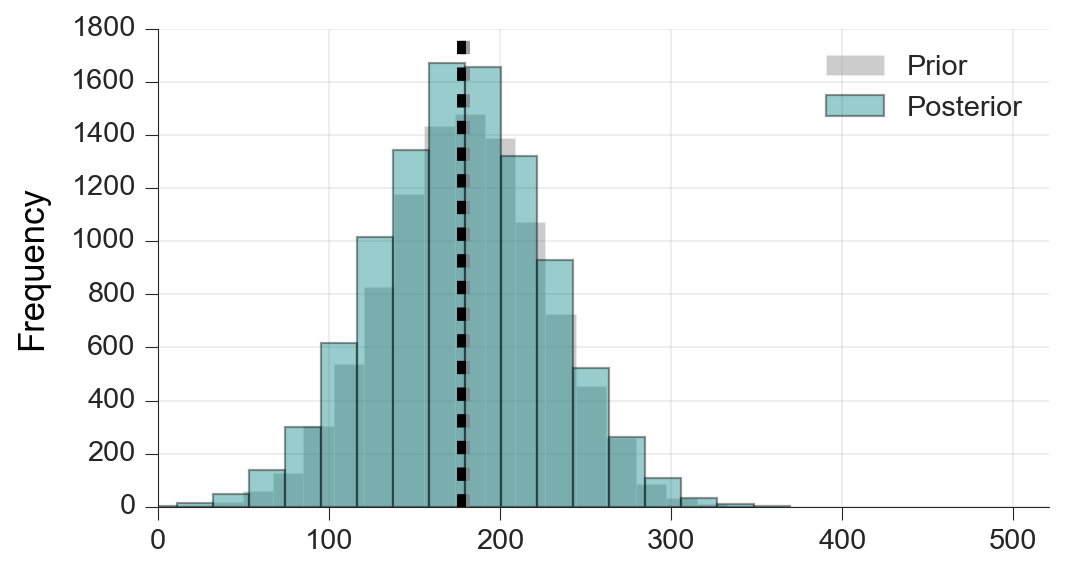

Devontae Booker


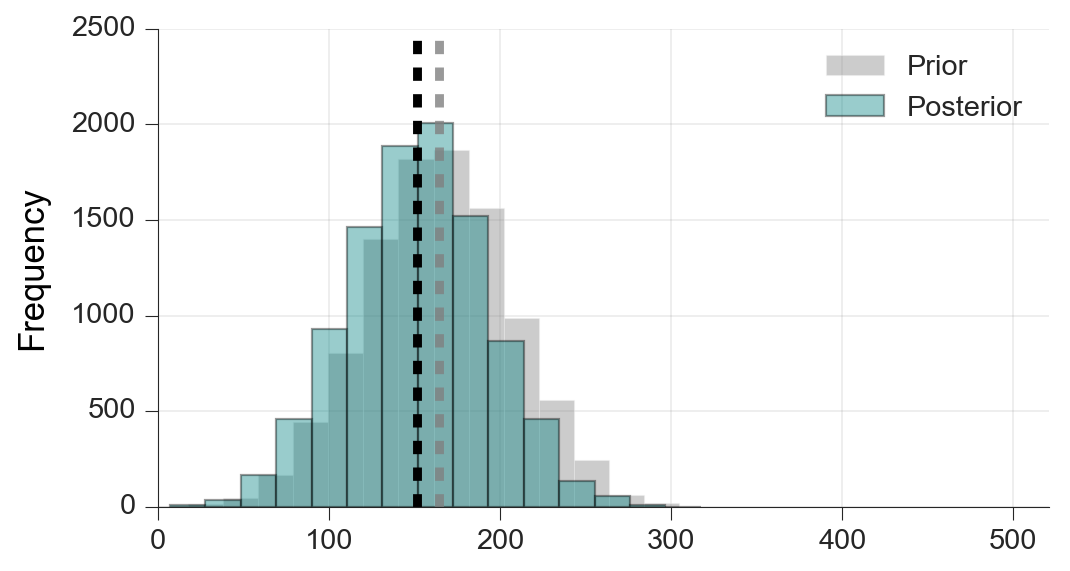

Chris Thompson


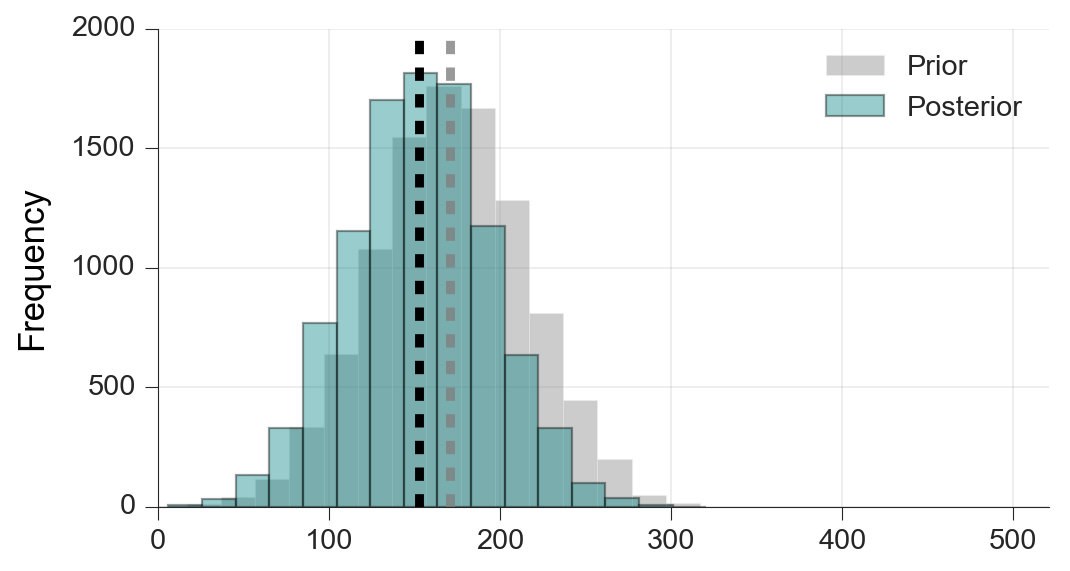

Isaiah Crowell


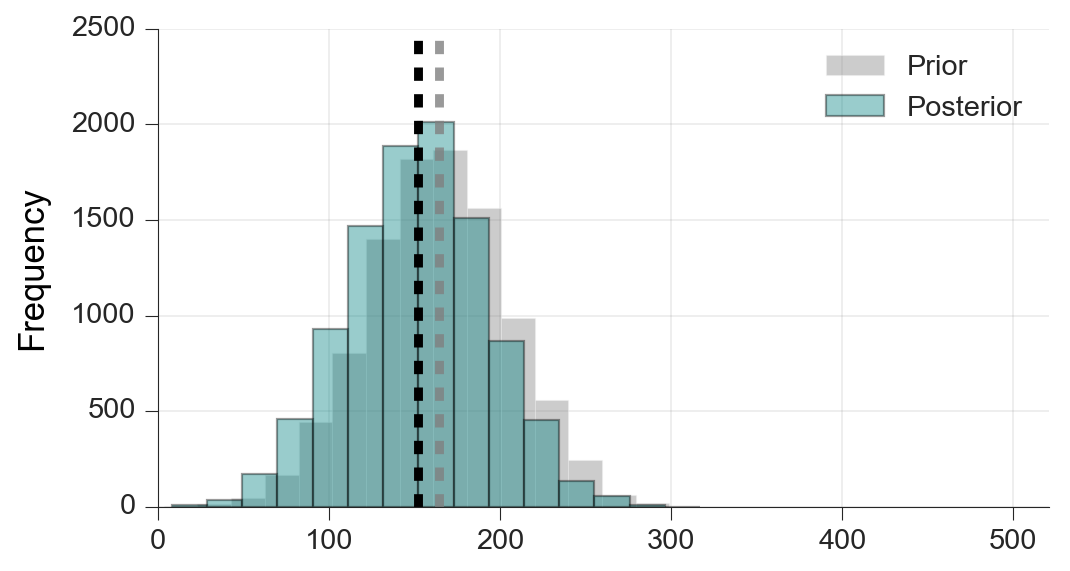

Carlos Hyde


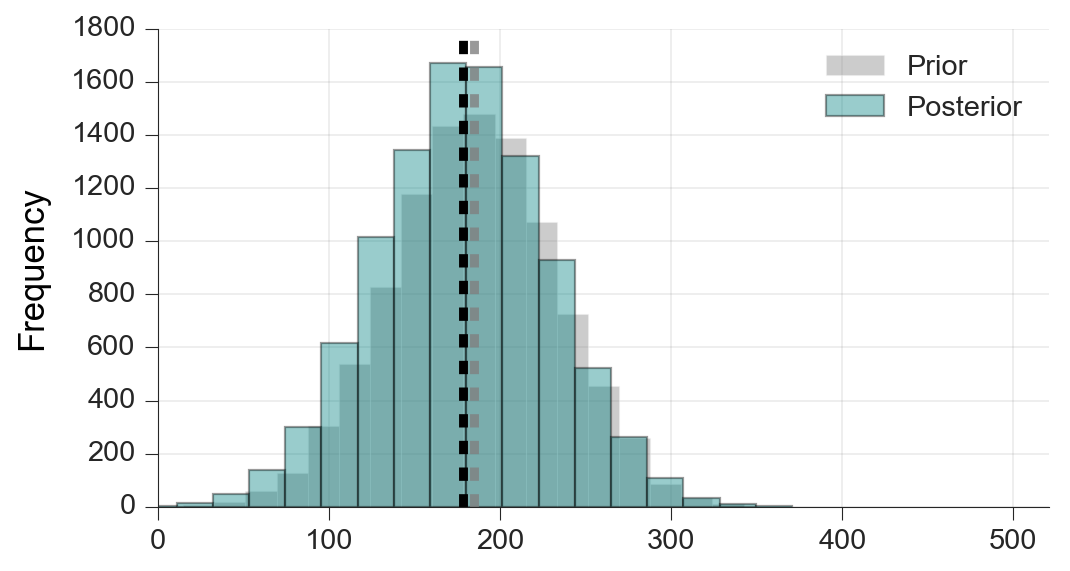

Frank Gore


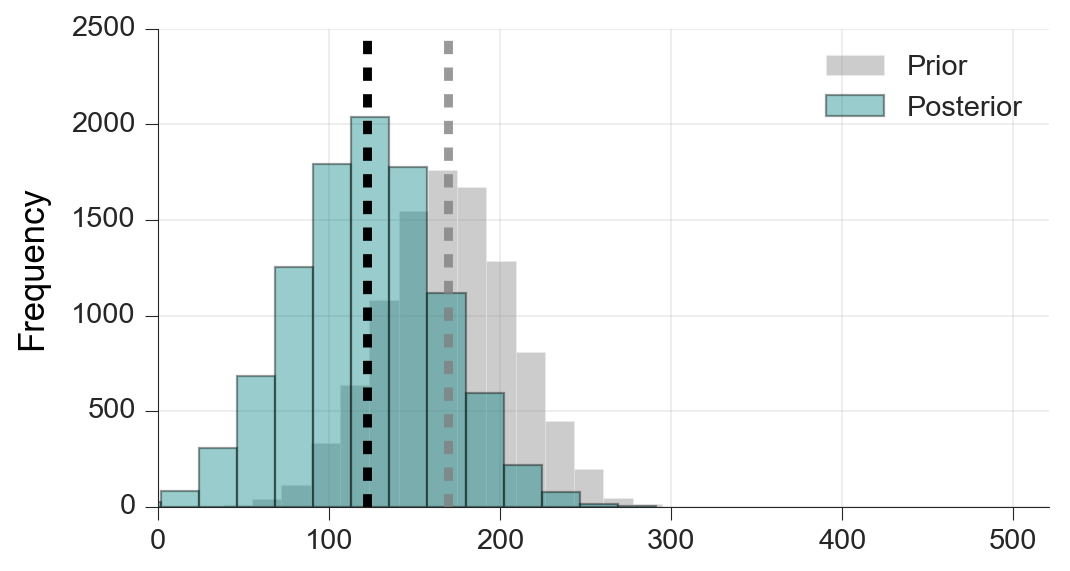

Ty Montgomery


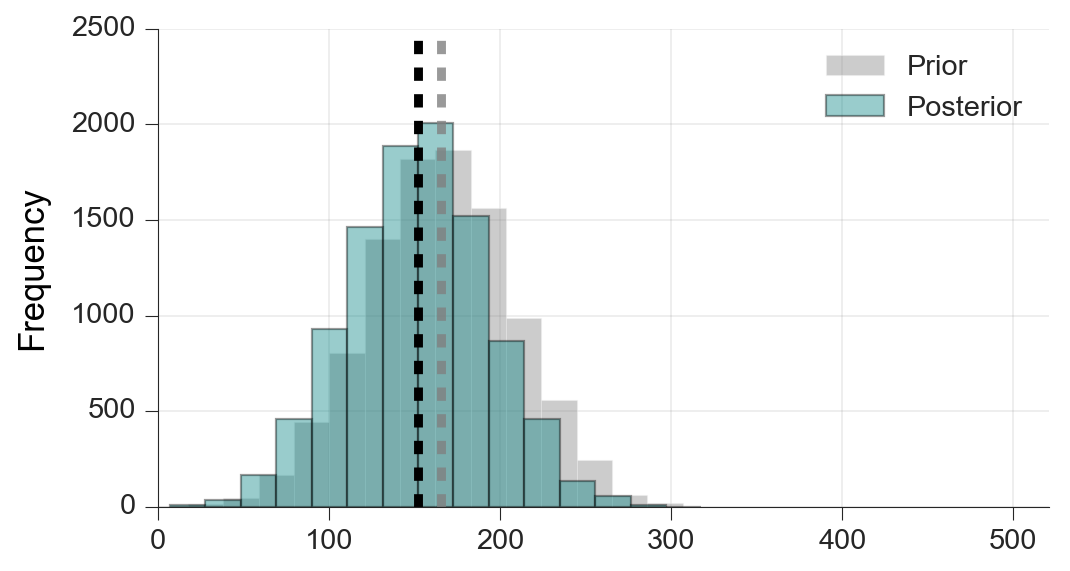

James White


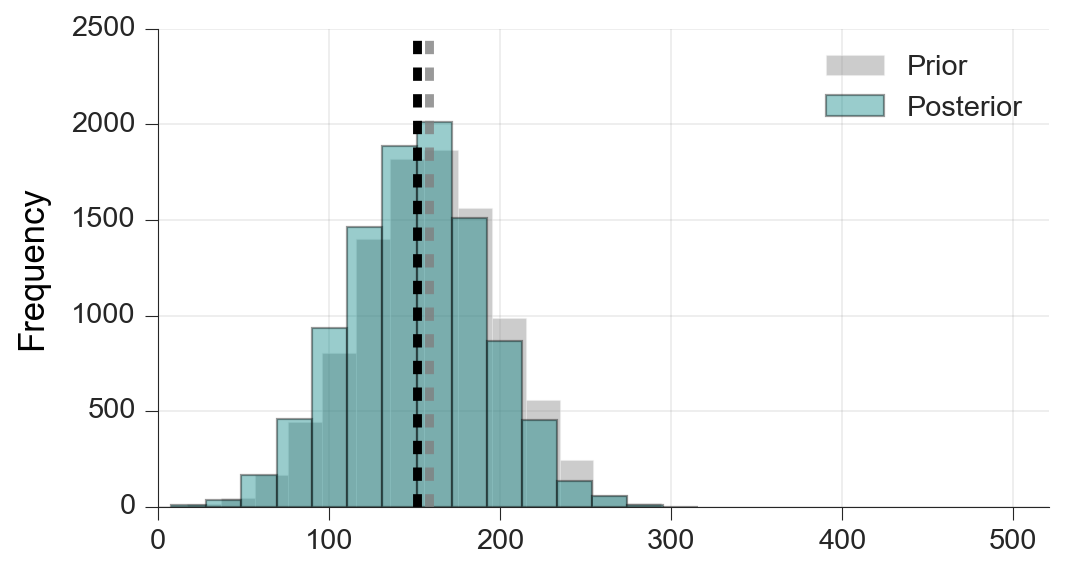

Bilal Powell


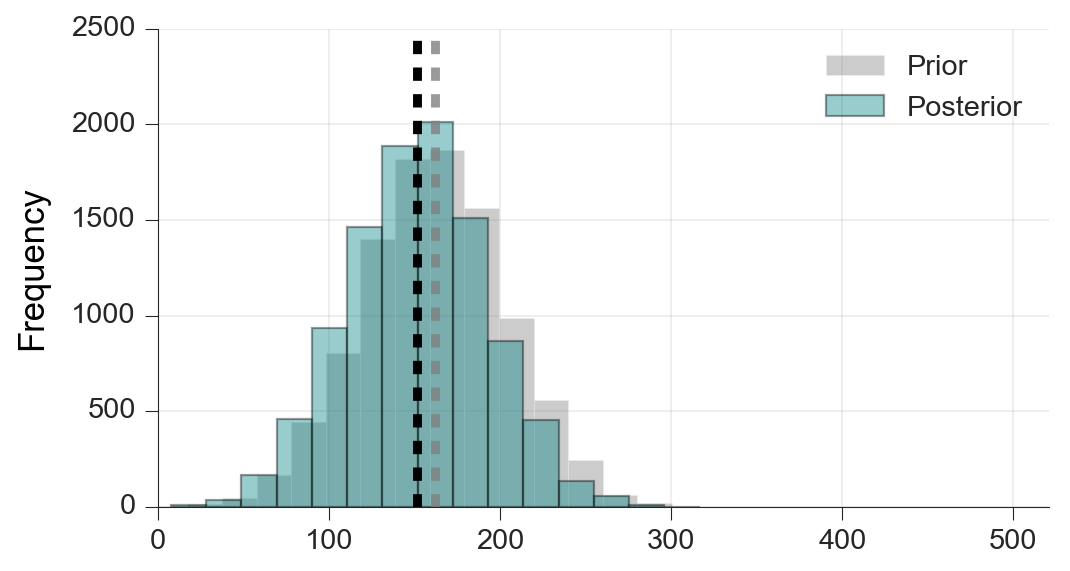

Theo Riddick


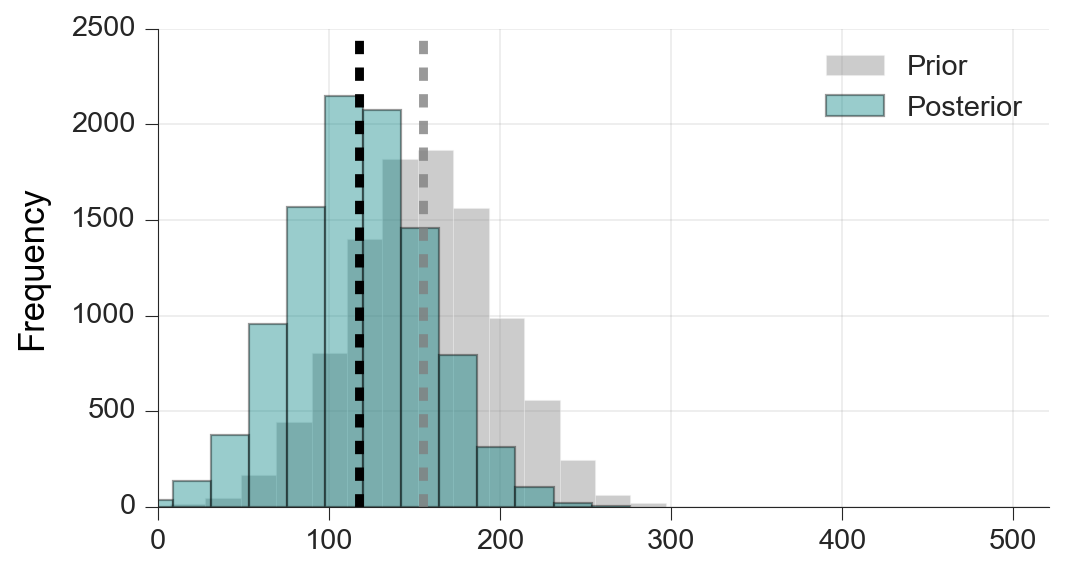

Aaron Jones


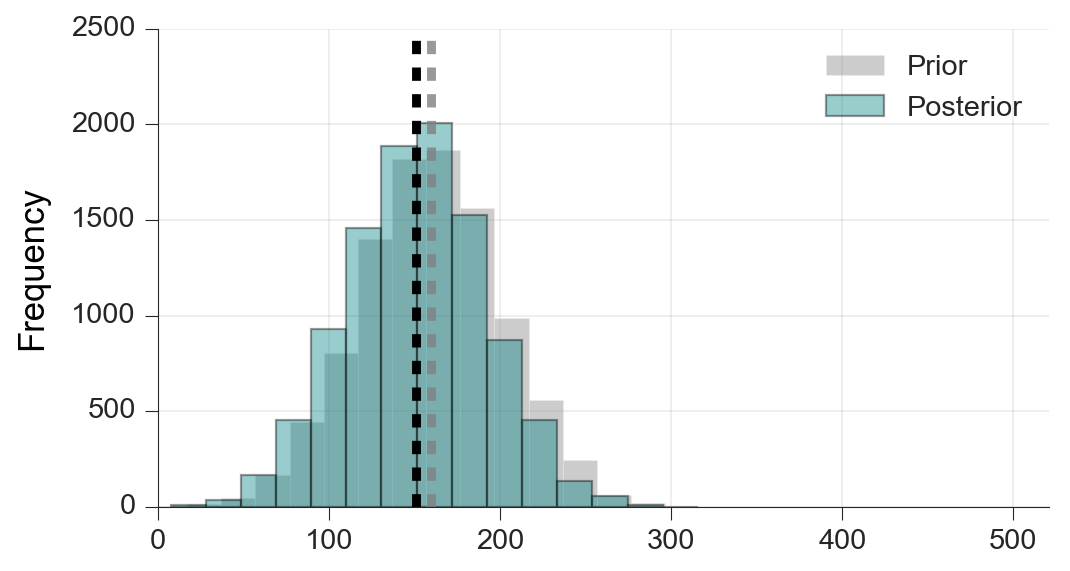

C.J. Anderson


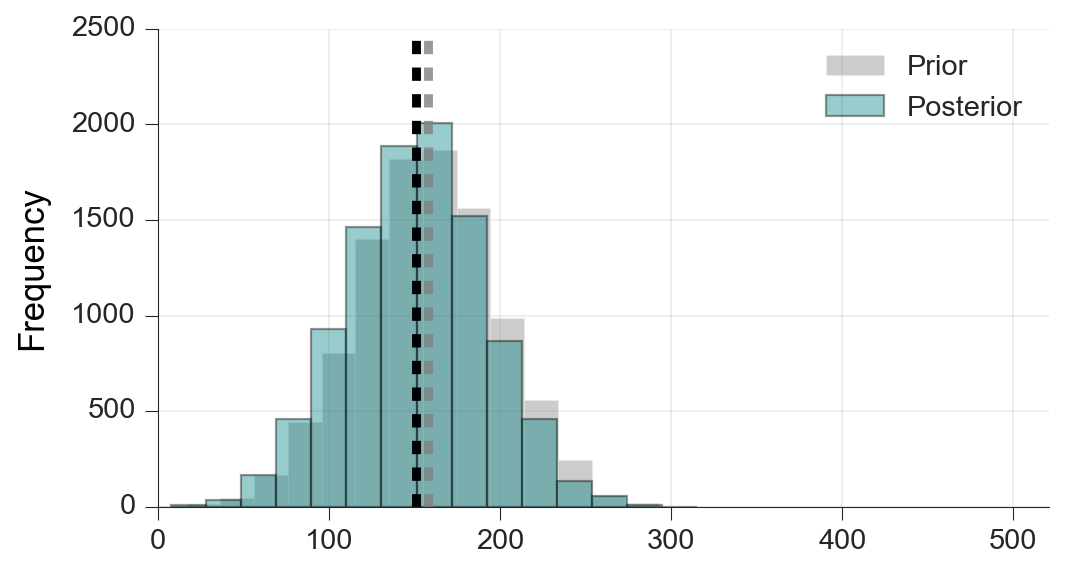

Javorius Allen


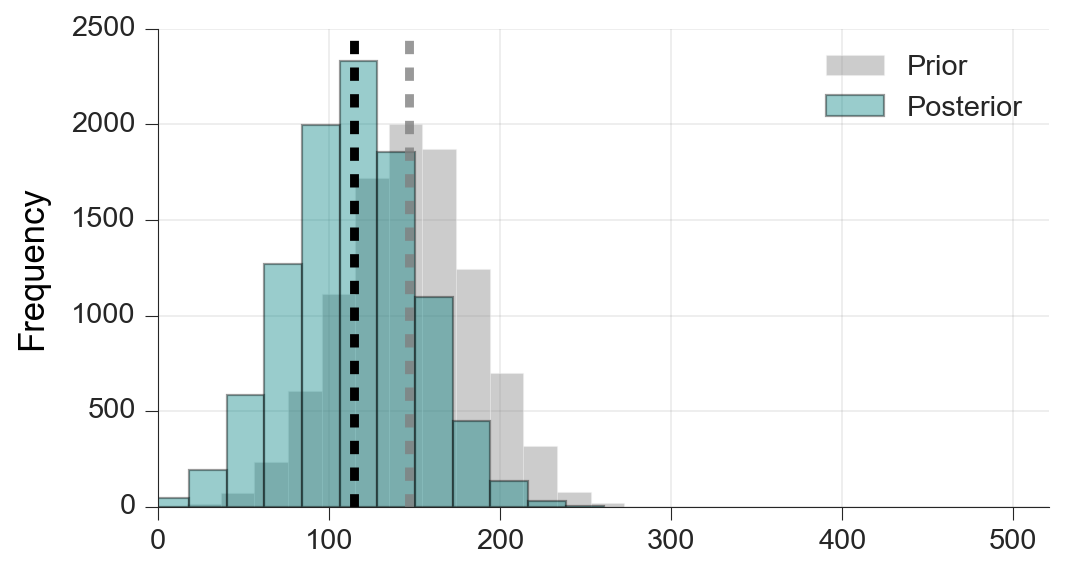

Latavius Murray


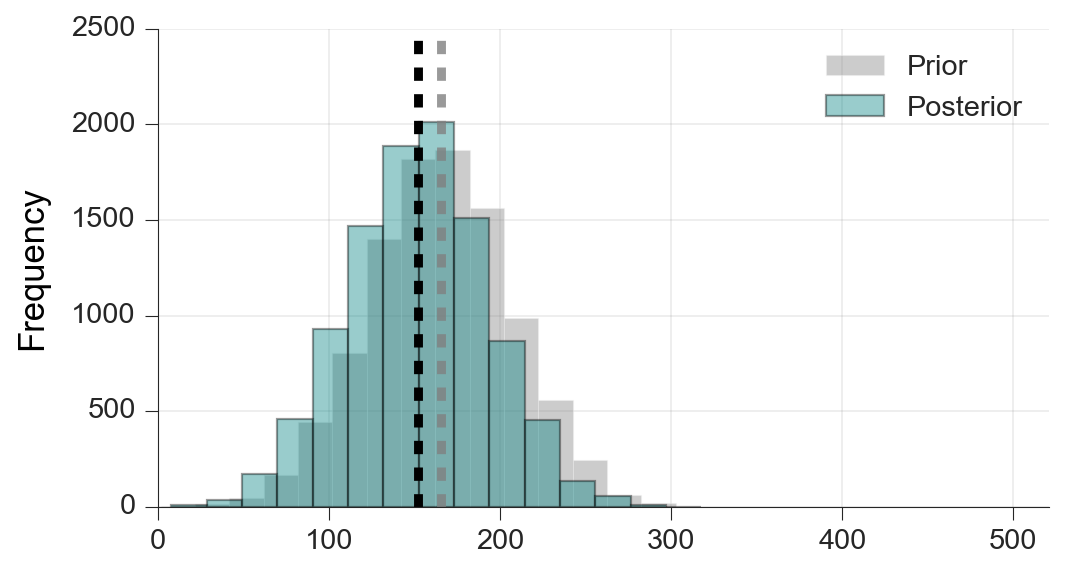

Austin Ekeler


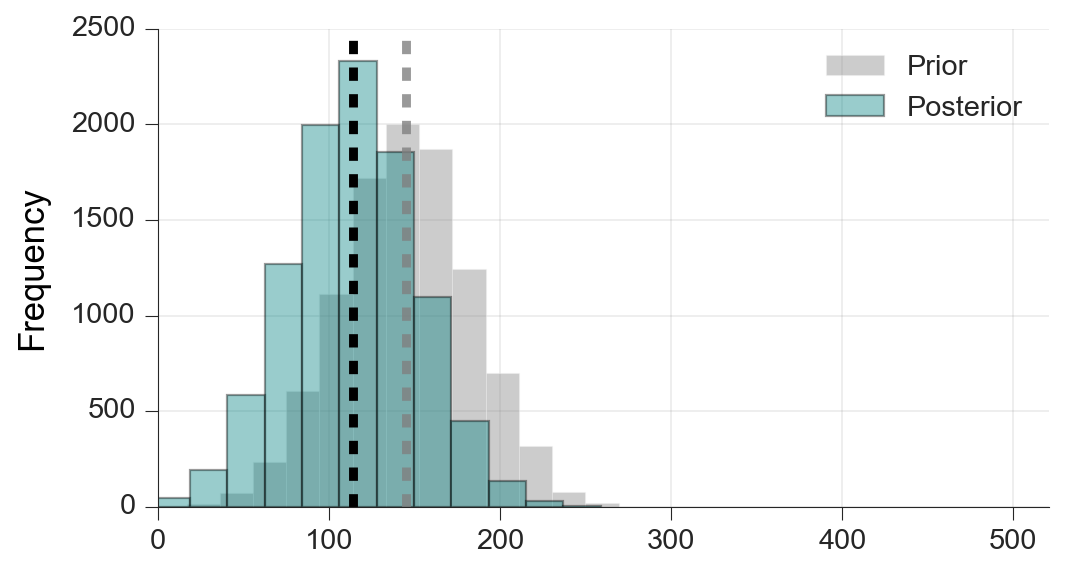

Wayne Gallman


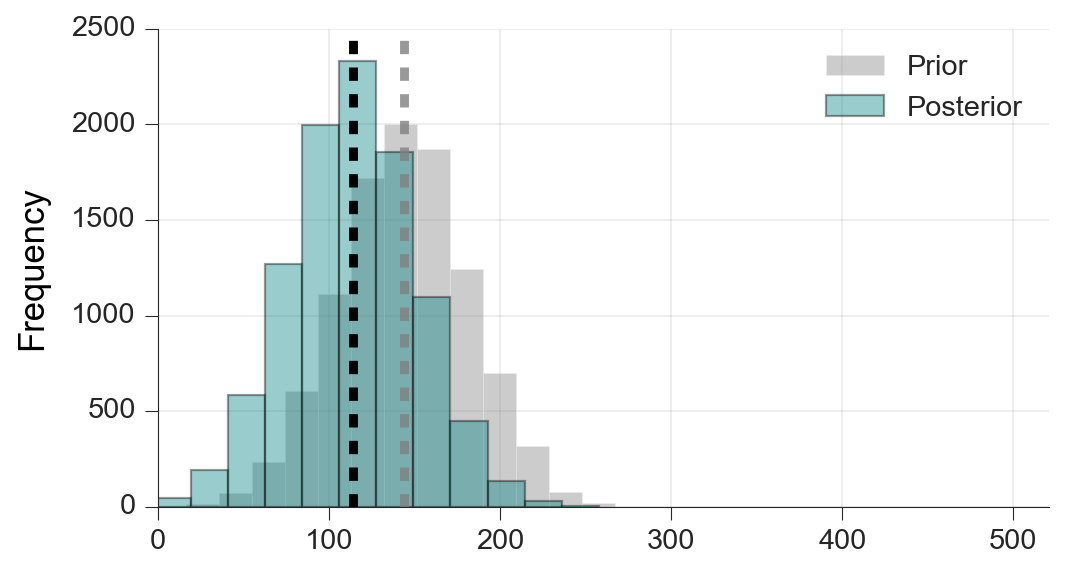

Jonathan Stewart


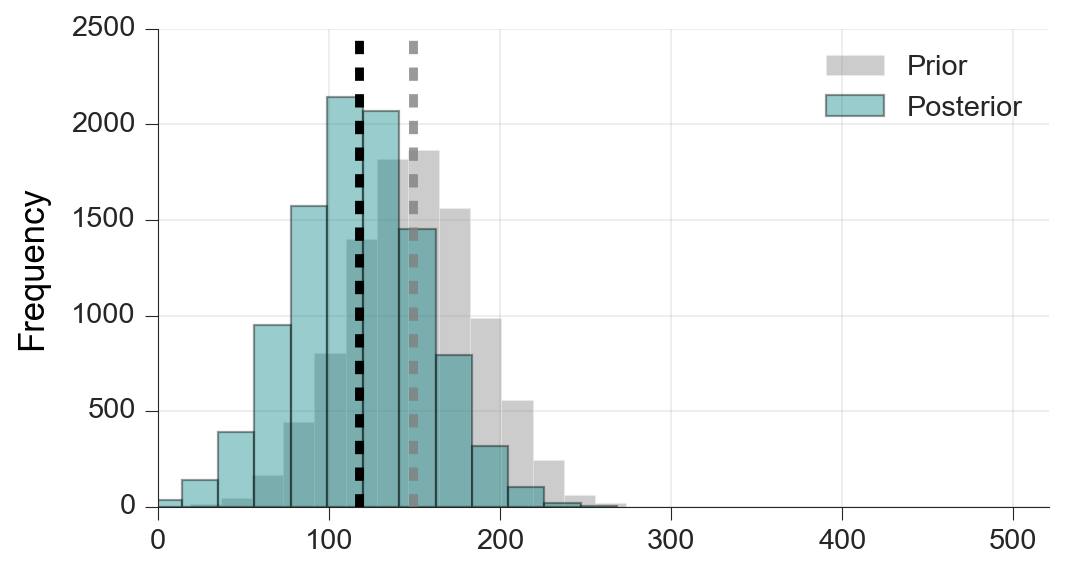

Doug Martin


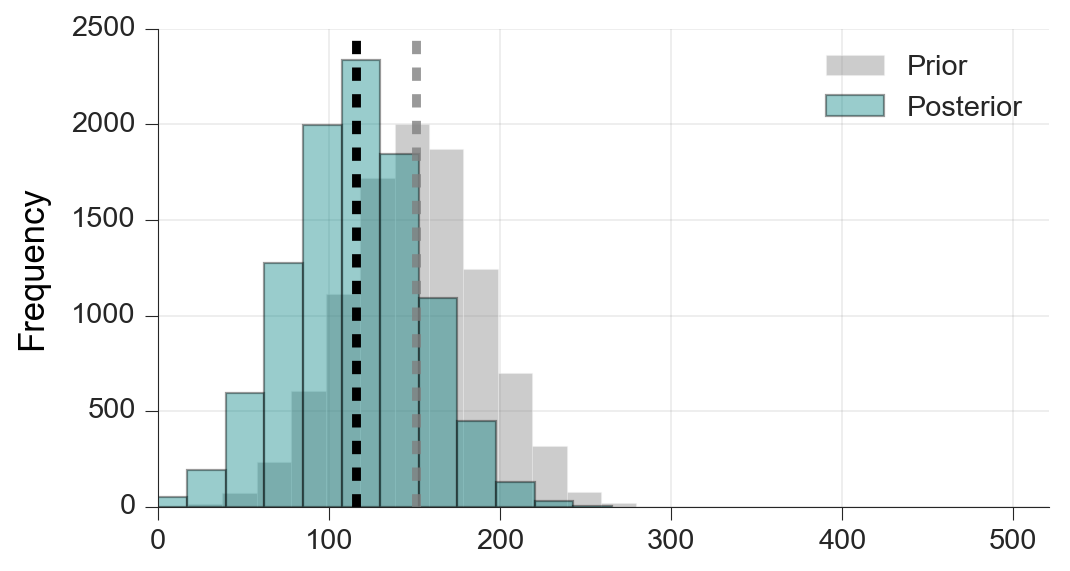

D'Onta Foreman


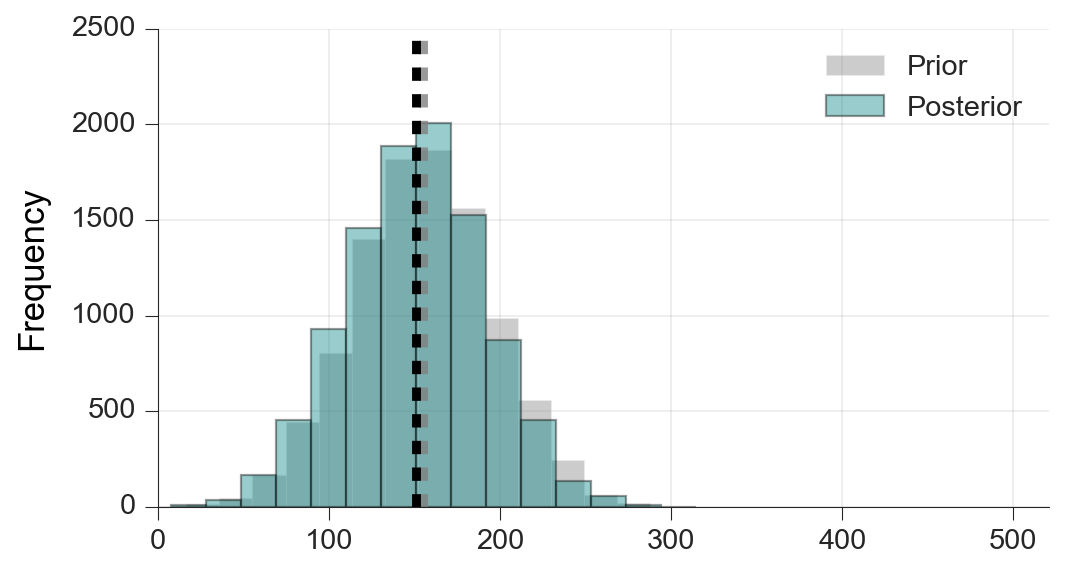

Darren Sproles


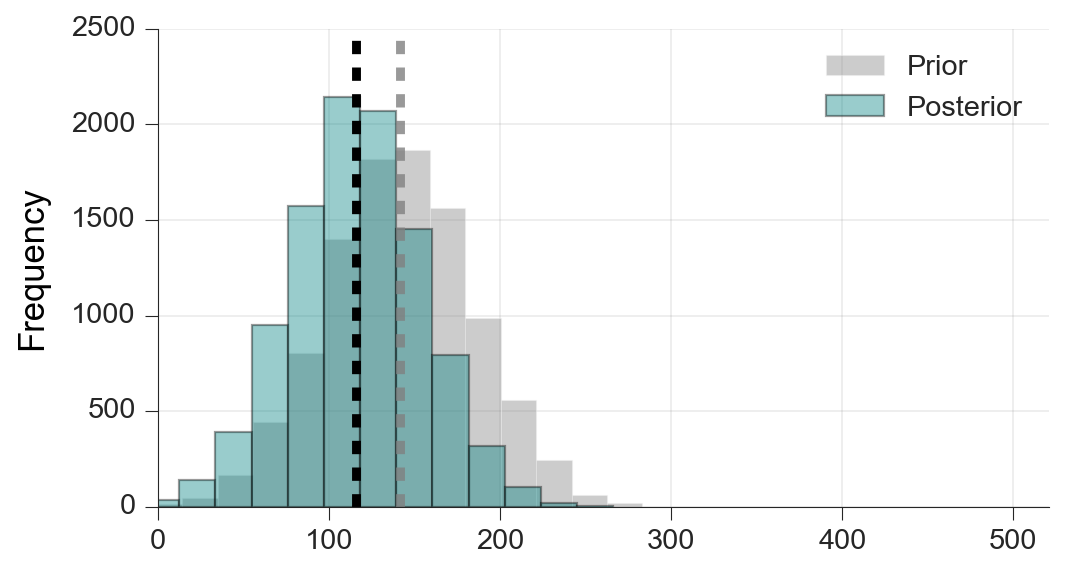

LeGarrette Blount


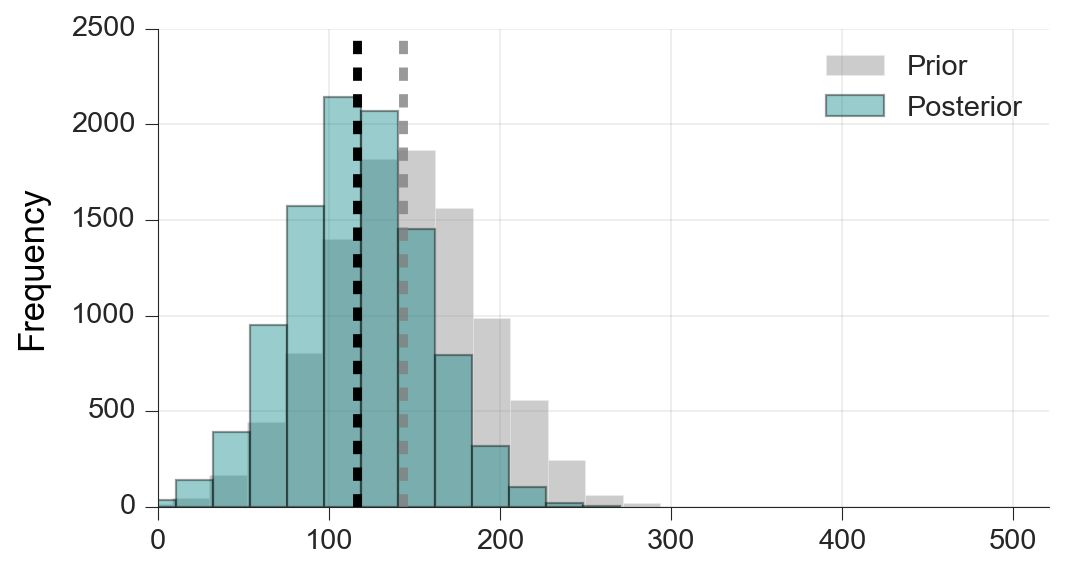

Matt Breida


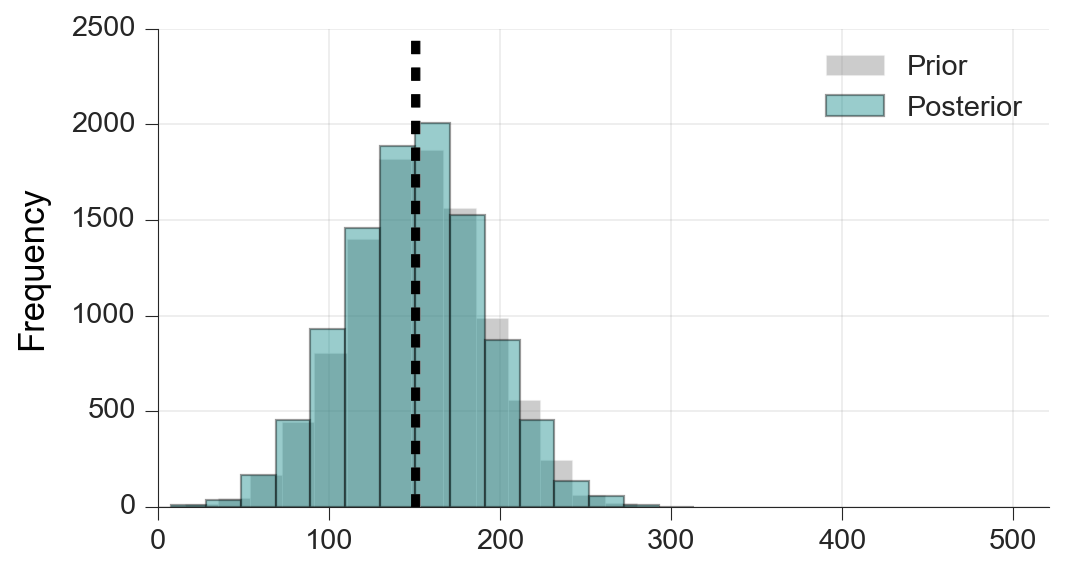

Corey Clement


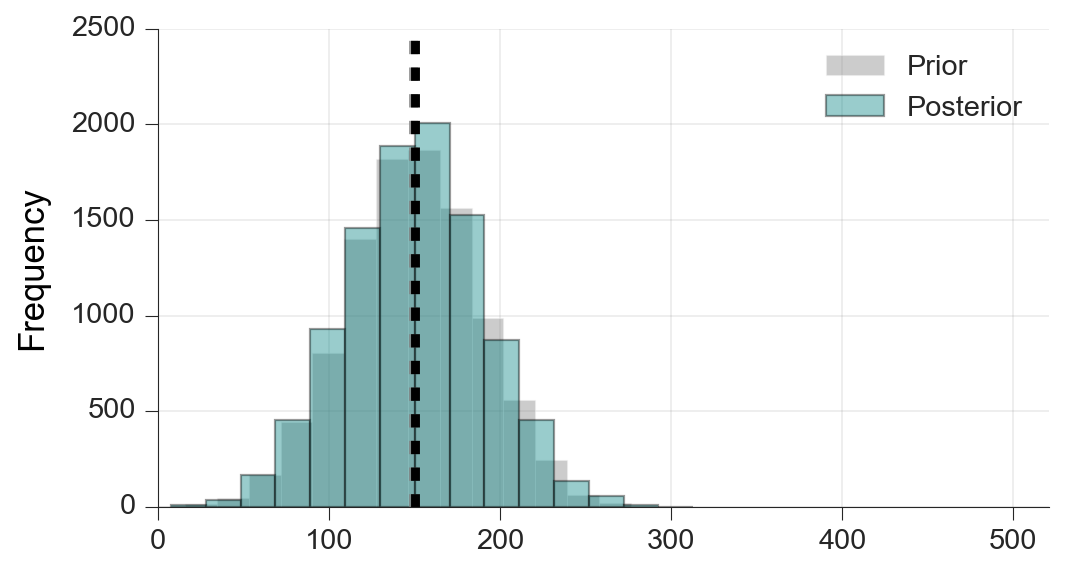

Chris Ivory


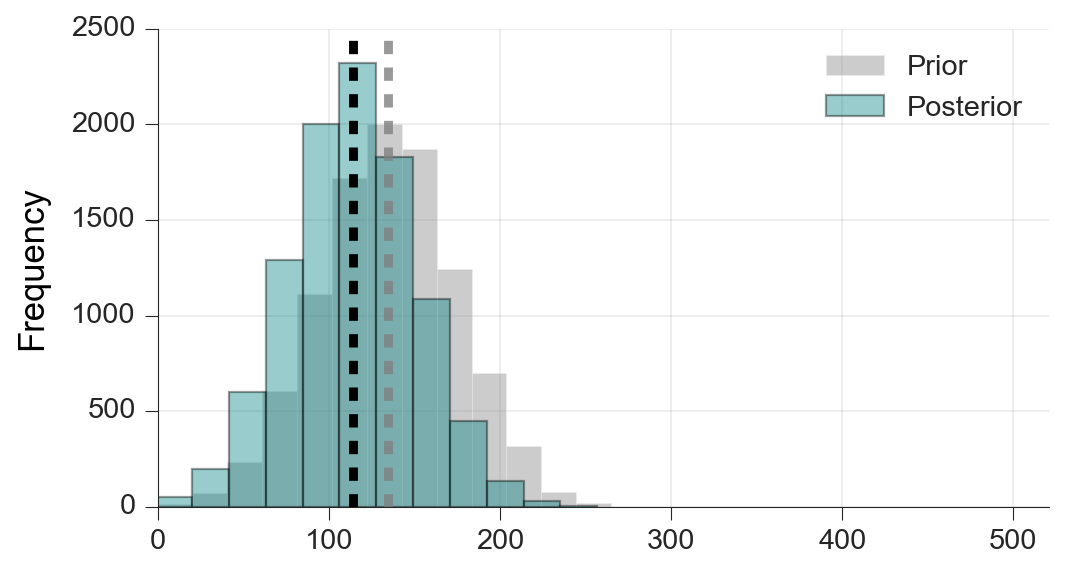

Jeremy Hill


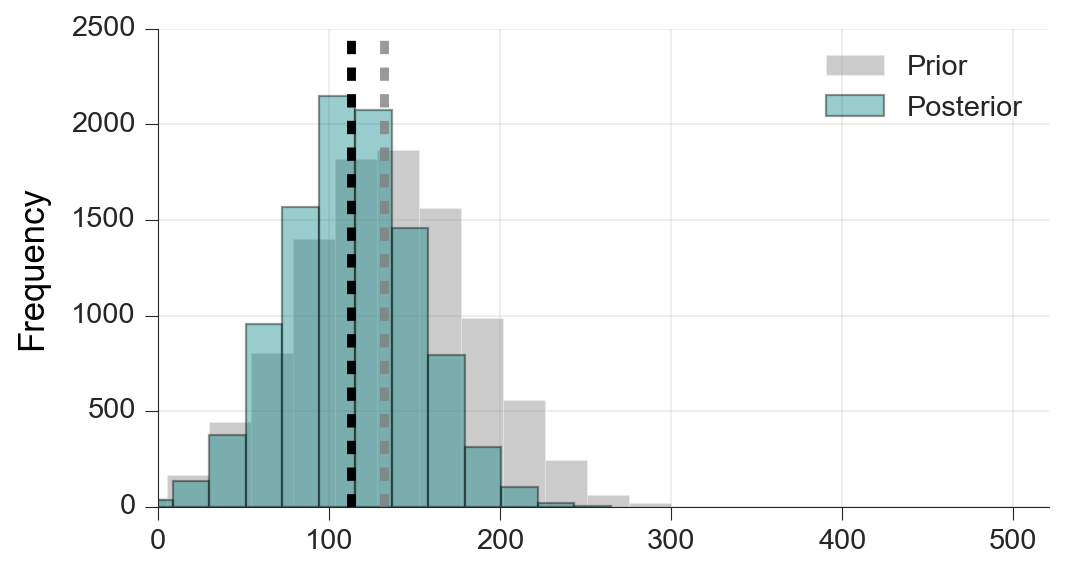

Samaje Perine


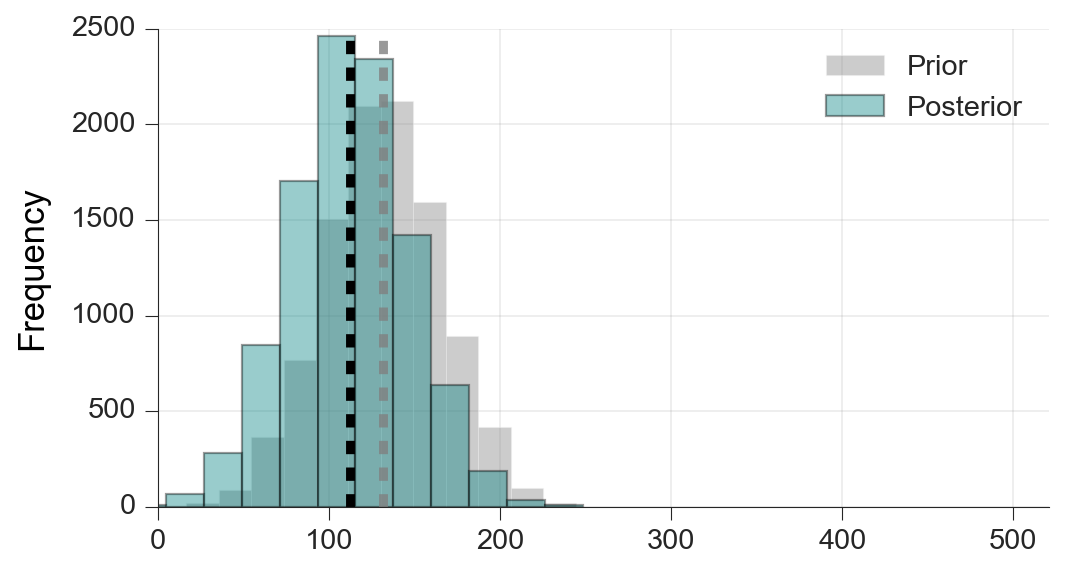

T.J. Yeldon


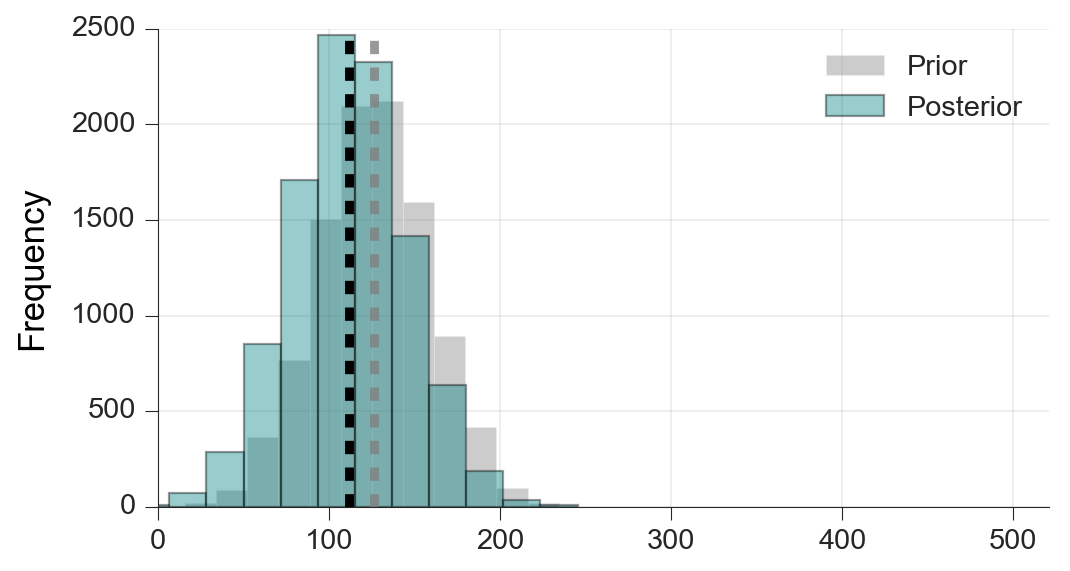

Rod Smith


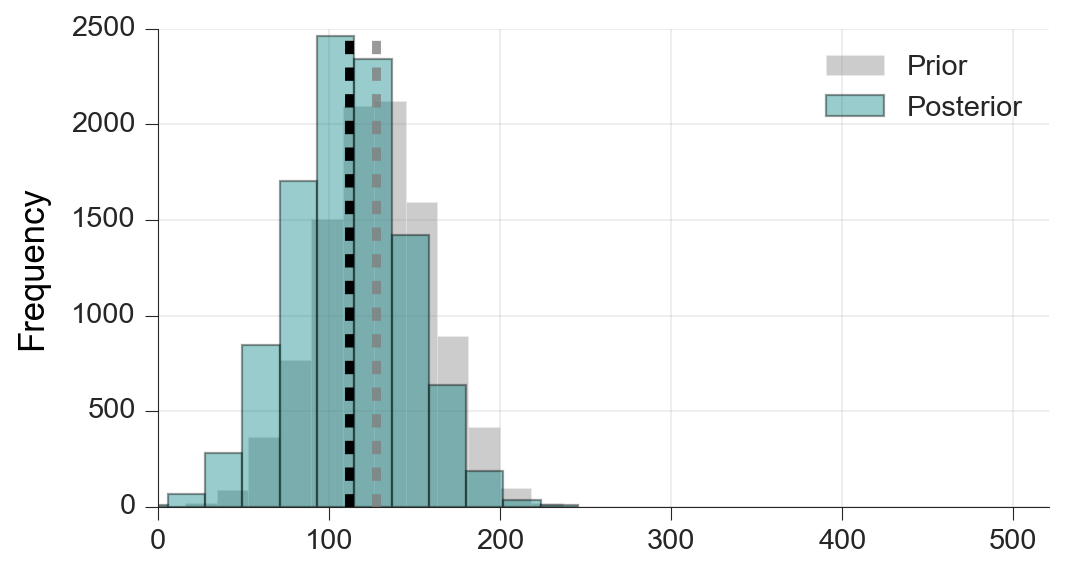

Alfred Morris


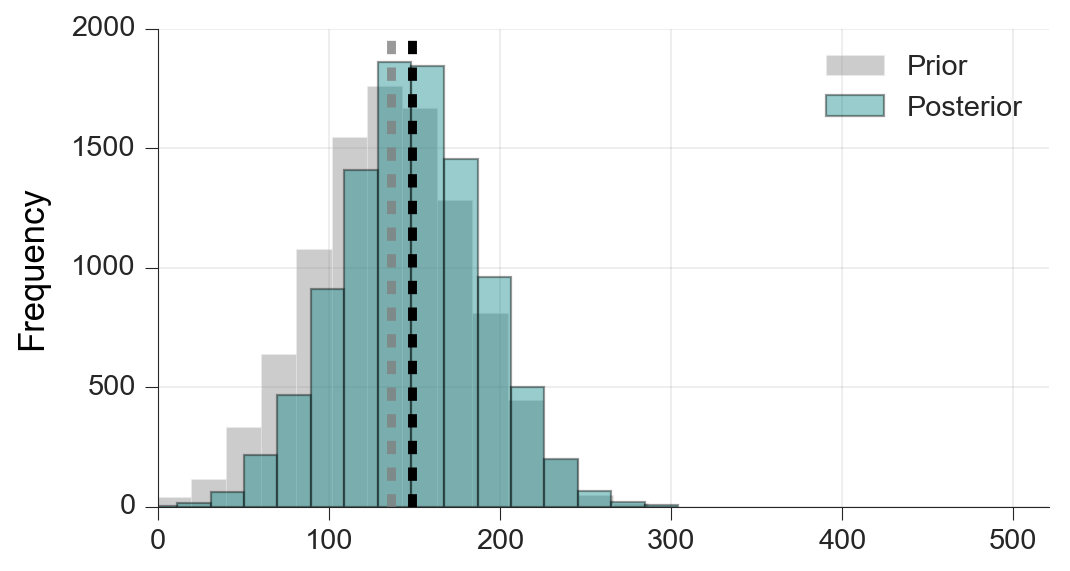

Jalen Richard


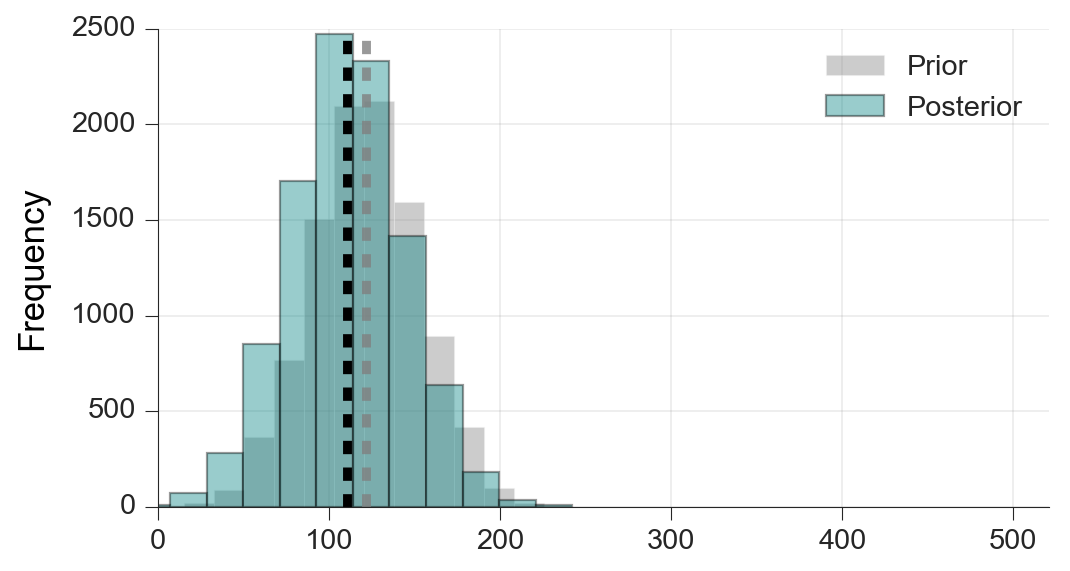

Ameer Abdullah


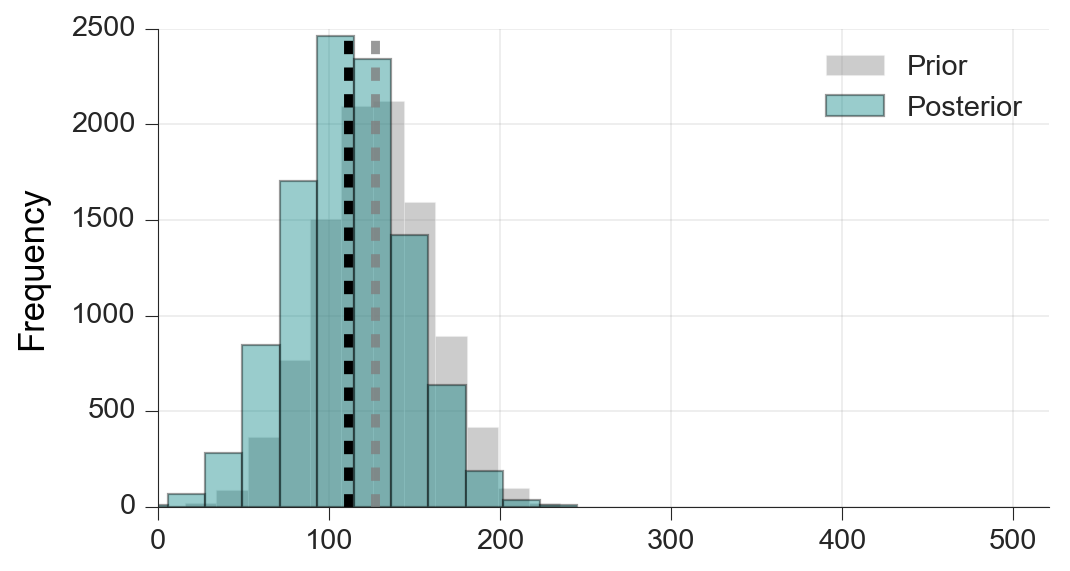

Elijah McGuire


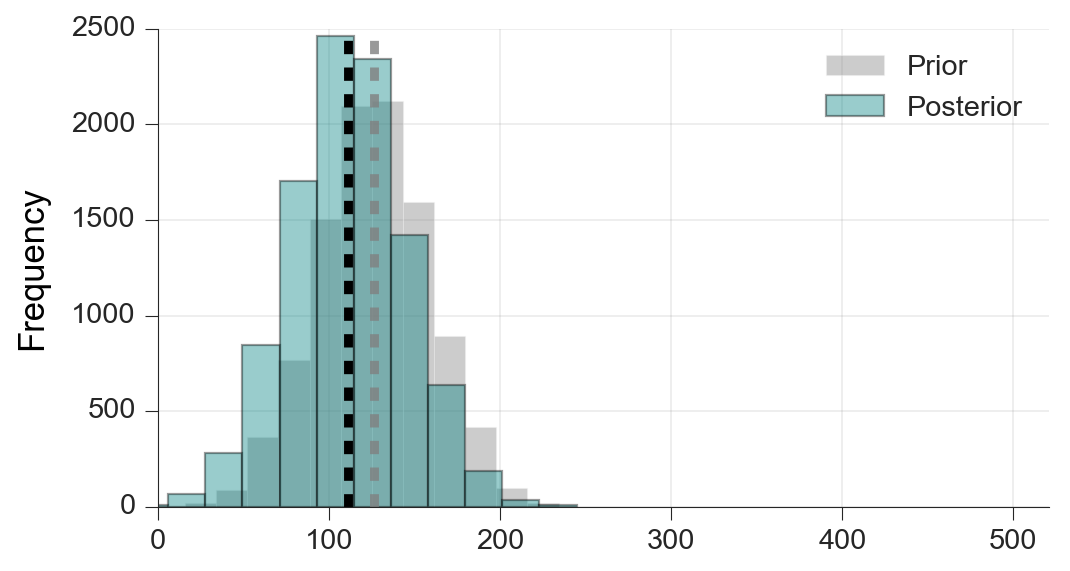

C.J. Prosise


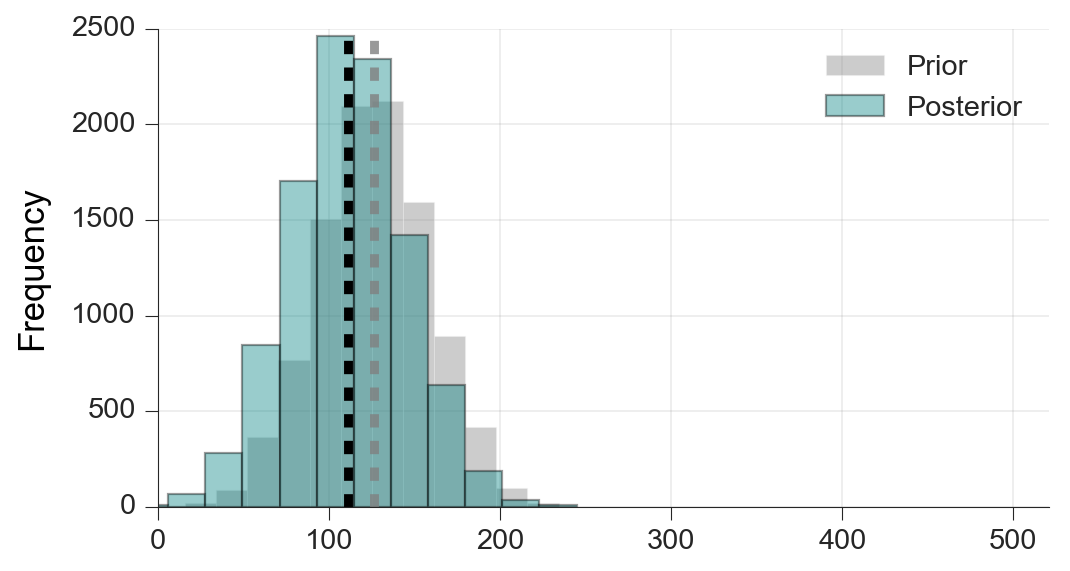

Alfred Blue


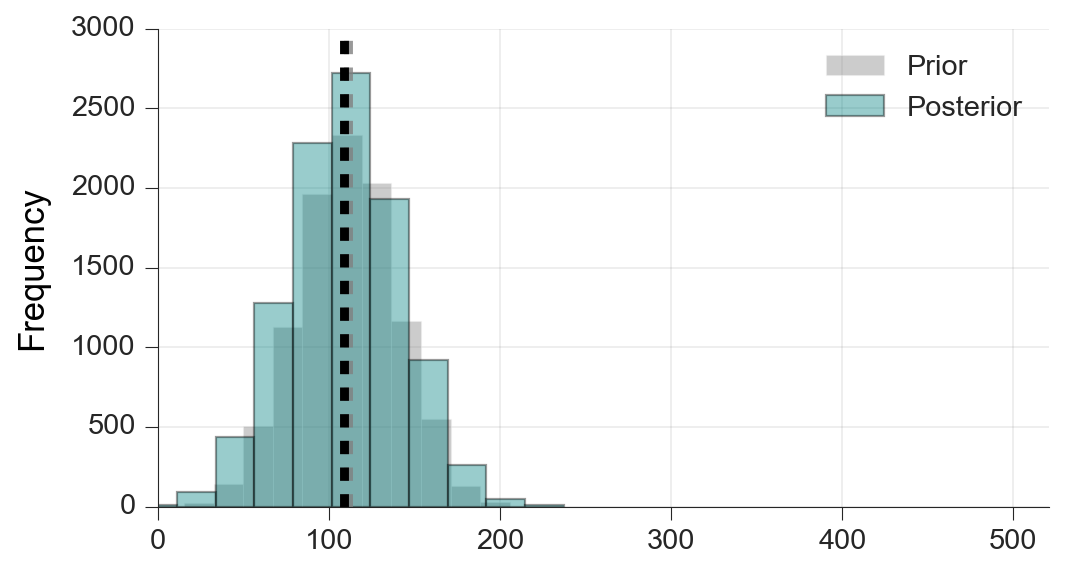

De'Angelo Henderson


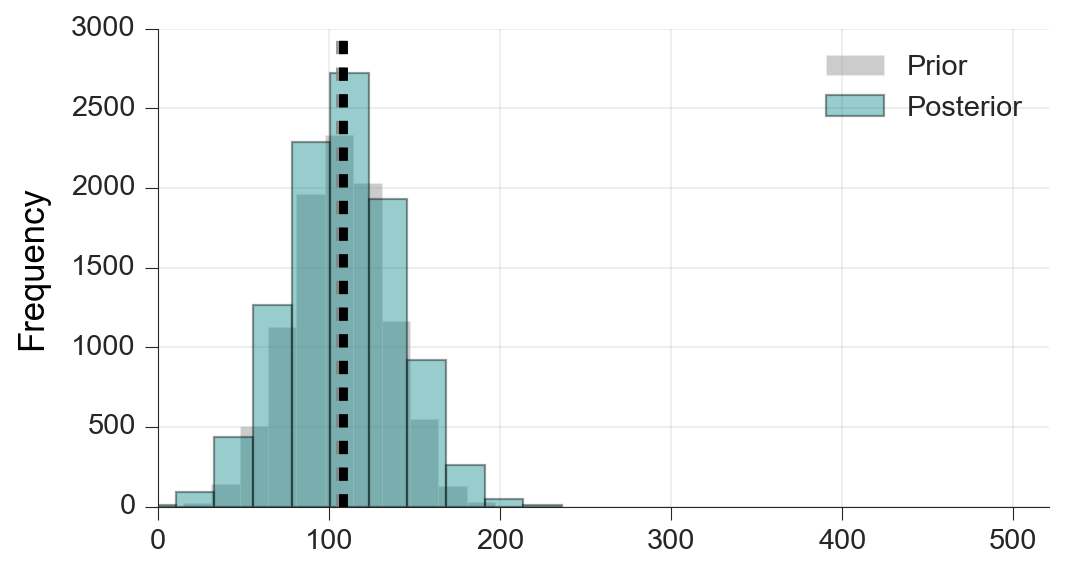

Corey Grant


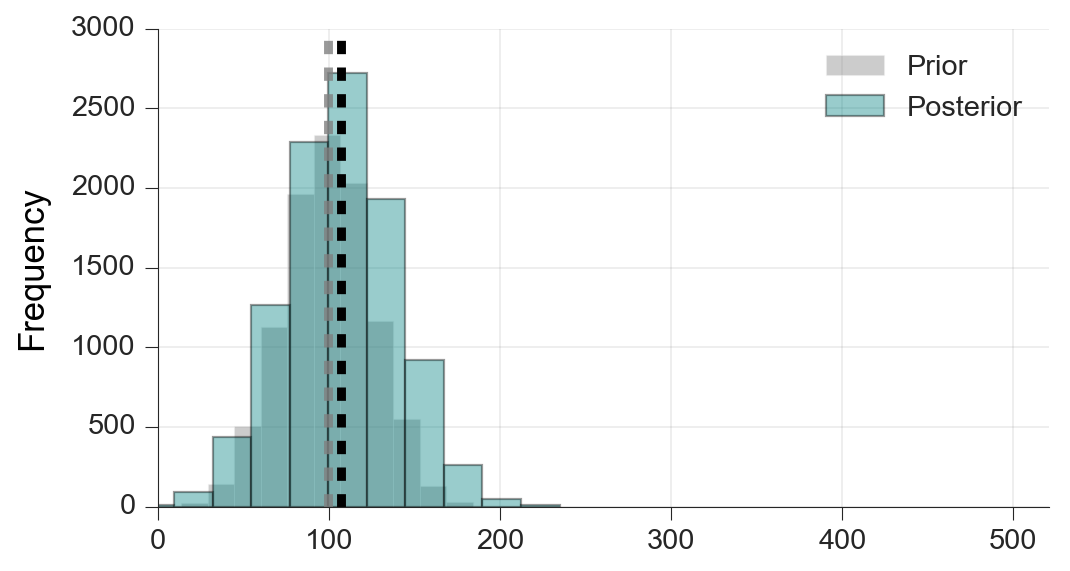

In [83]:
#==========
# Create the Distributions and Plot Prior / Posterior Results
#==========

distributions = cluster.create_distributions(prior_repeats=5)

In [ ]:
distributions.to_csv(path + 'Results/' + str(set_year) + '/' + set_pos + '_Distributions.csv', index=False)